In [1]:
# ! pip install ultralytics
# ! pip install splitfolders

# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from termcolor import colored
import os
import warnings
import random
import shutil
import cv2
import splitfolders
from datetime import datetime
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import gc
from termcolor import colored
import torch
from torchvision.models import googlenet, GoogLeNet_Weights
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights
import torch.nn as nn
from ultralytics import YOLO
from sklearn.metrics import confusion_matrix, classification_report 
from PIL import Image

In [3]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

# Data Loading

In [4]:
working_dir = 'C:\\envs\\Working\\Iranian_Plates'
alphabet_base = 'C:\\envs\\DataSets\\large-dataset-of-persian-license-plate-characters\\chars\\'

In [5]:
alphabet_classes = os.listdir(alphabet_base)
print(f'Number of folders in ALPHABET-DIR : {len(alphabet_classes)}')

Number of folders in ALPHABET-DIR : 24


## Copy

In [6]:
# make a directory for alphabet images in working-dir
alphabet_dir = os.path.join(working_dir, 'alphabet')

if not os.path.exists(alphabet_dir) :
    os.mkdir(alphabet_dir)

In [7]:
# def Copy_Alphabet_Chars() :
#     for class_name in tqdm(alphabet_classes) :
#         # read class name and change it
#         new_name = 'char_'+class_name
#         # Create new class name in working dir
#         dest_class_path = os.path.join(alphabet_dir, new_name)
#         os.mkdir(dest_class_path)

#         # read images from source dir
#         class_path = os.path.join(alphabet_base, class_name)
#         class_path = os.path.join(class_path, '2')
#         class_files = [file_name for file_name in os.listdir(class_path) if file_name.endswith('.jpg')]
#         # Loop over source folders and copy to destinations
#         for img in class_files :
#             src = os.path.join(class_path, img)
#             dst = os.path.join(dest_class_path, img)
#             shutil.copy(src=src, dst=dst)

# Copy_Alphabet_Chars()

In [8]:
# Re-Define aplhabet-classes with copyed foders
alphabet_classes = os.listdir(alphabet_dir)

# Convert to Gray-Scale

In [9]:
# def Convert_Colored_To_GrayScale() :
#     '''
#     Convert Colored images to GrayScale .
#     '''

#     for class_name in tqdm(alphabet_classes) :
#         class_path = os.path.join(alphabet_dir, class_name)
#         class_images = [os.path.join(class_path, file_name) for file_name in os.listdir(class_path)]


#         for image_path in class_images :
#             img = cv2.imread(image_path, 0)
#             cv2.imwrite(image_path, img)

# Convert_Colored_To_GrayScale()

# Plot Counts of files

In [10]:
def Counts_Of_Files(alphabet_dir) :
    '''
    Counts number of files in each directory and stored in a List
    '''
    counts = []
    # alphabet_classes = os.listdir(alphabet_dir)

    for class_name in alphabet_classes :
        class_path = os.path.join(alphabet_dir, class_name)
        count = len(os.listdir(class_path))
        counts.append(count)
    return counts

counts = Counts_Of_Files(alphabet_dir)

In [11]:
print(f'Number of all images : {sum(counts)}')

Number of all images : 20145


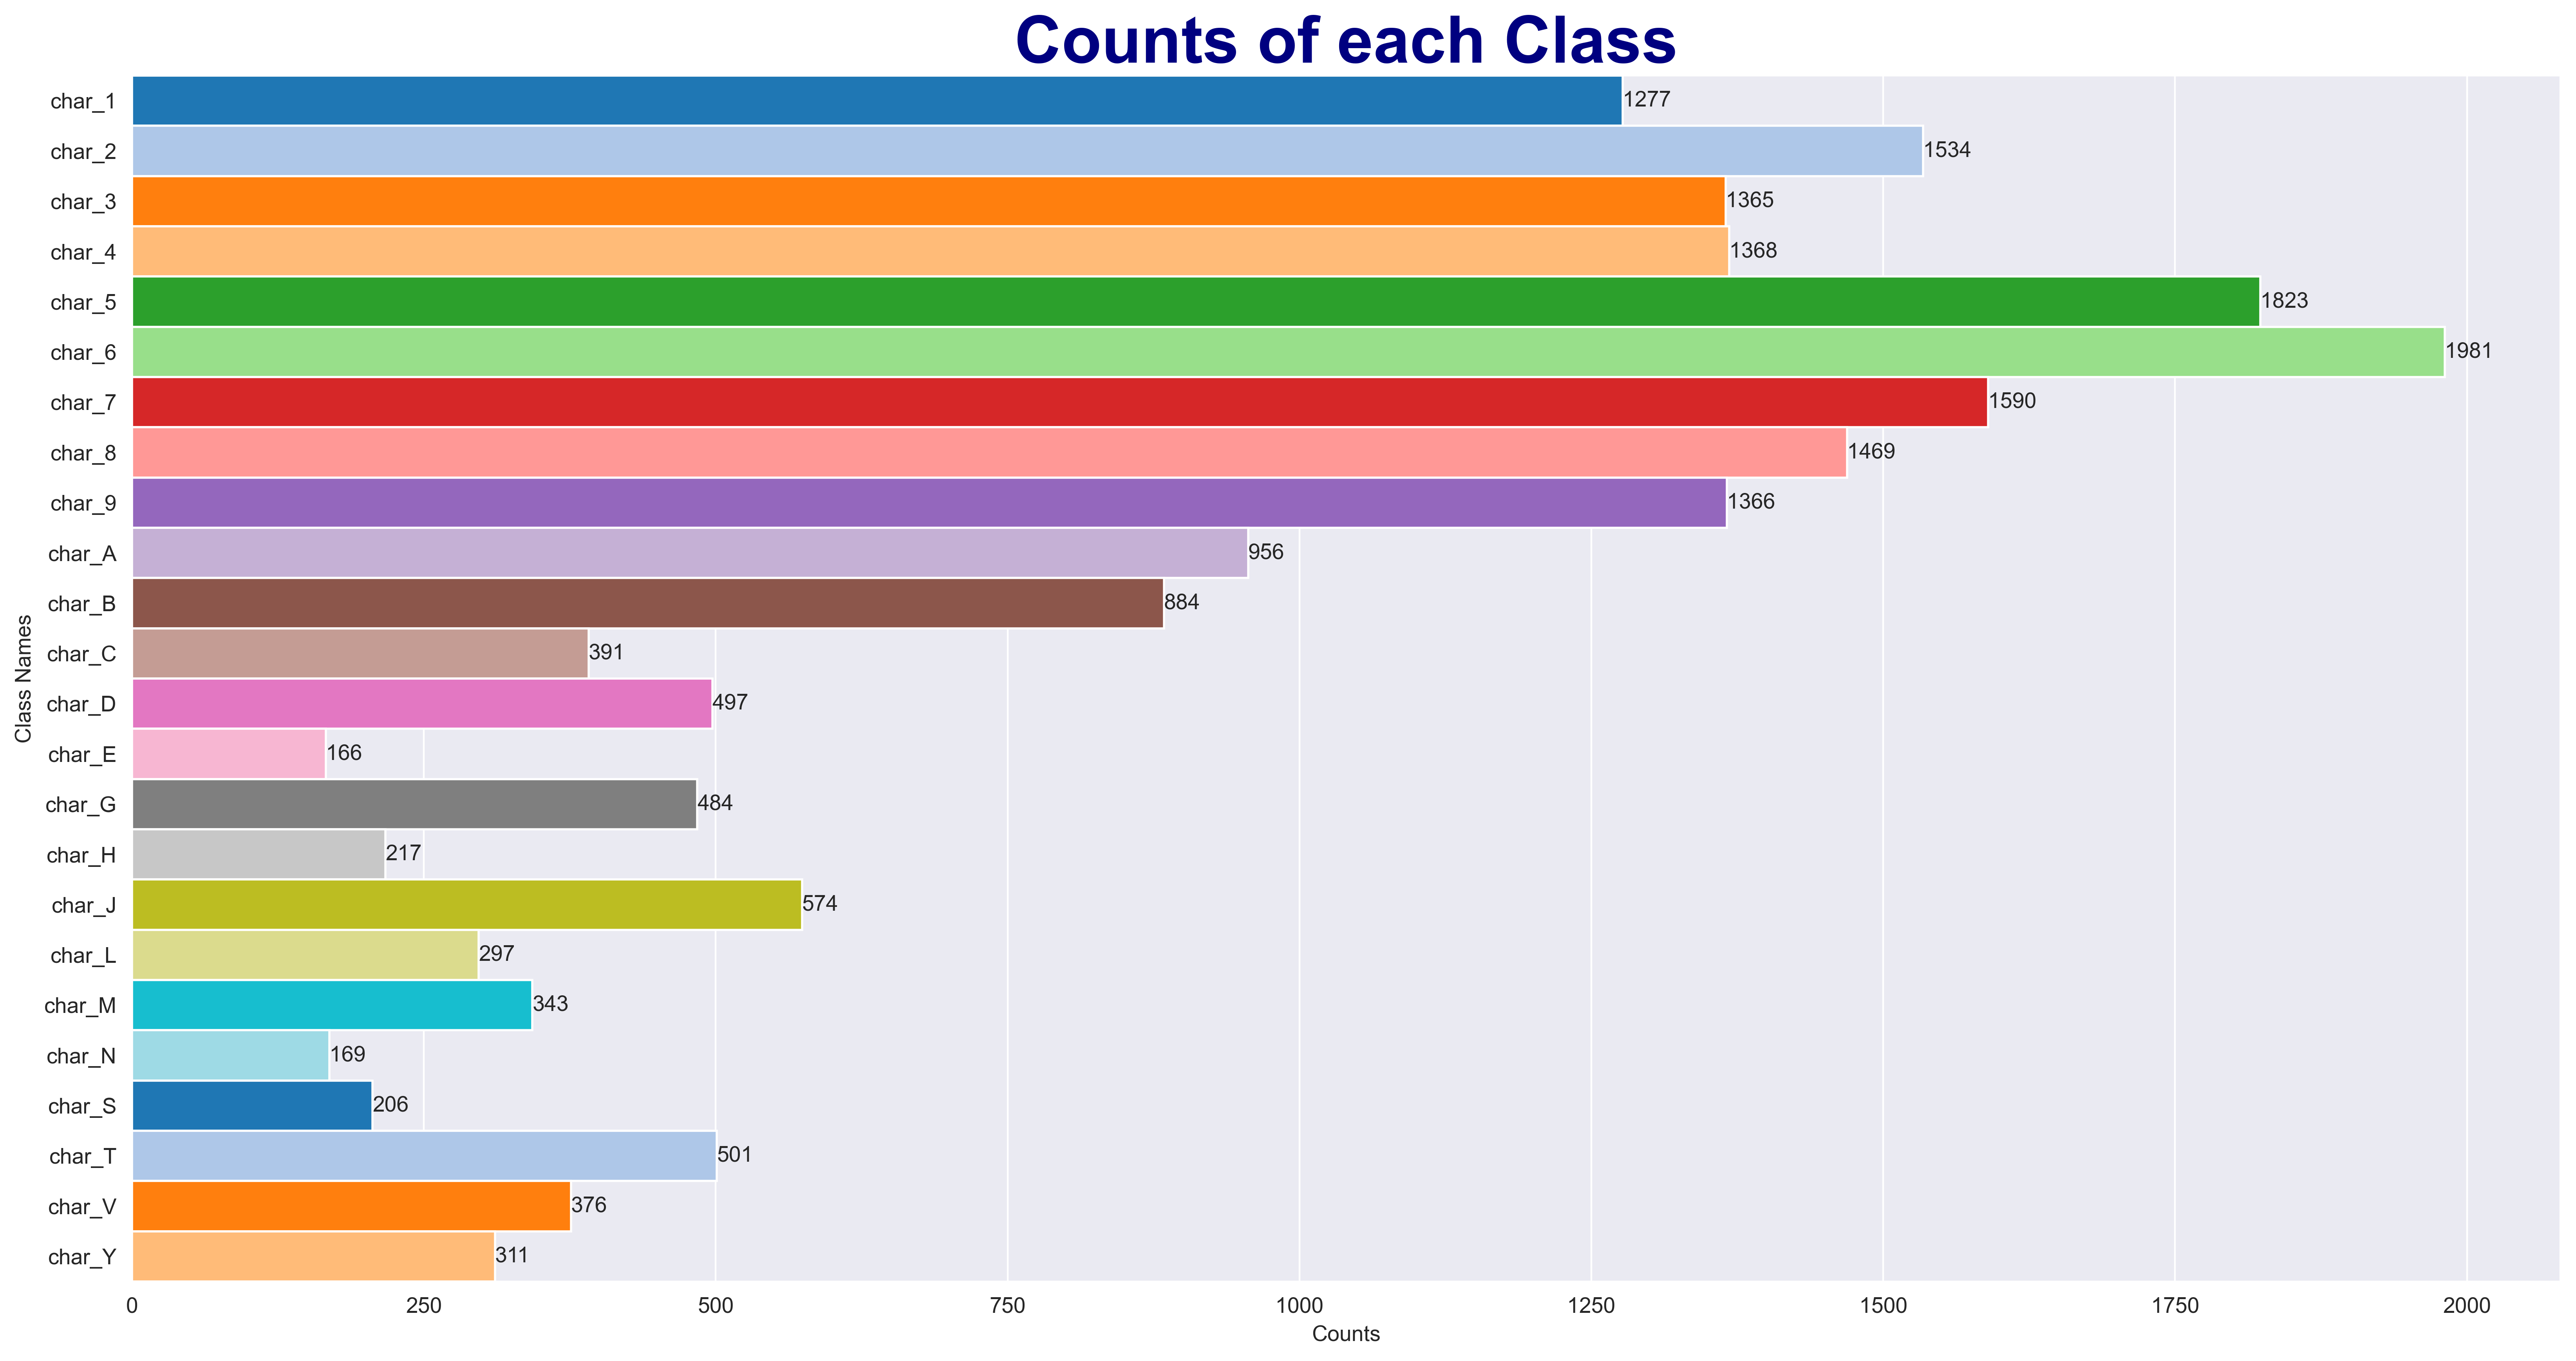

In [12]:
plt.figure(figsize=(20, 10), dpi=400)
ax = sns.barplot(x=counts, hue=alphabet_classes,y=alphabet_classes, palette='tab20', saturation=1.0, width=1.0)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Counts of each Class', fontsize=30, fontweight='bold', c='navy')
plt.ylabel('Class Names')
plt.xlabel('Counts')
plt.show()

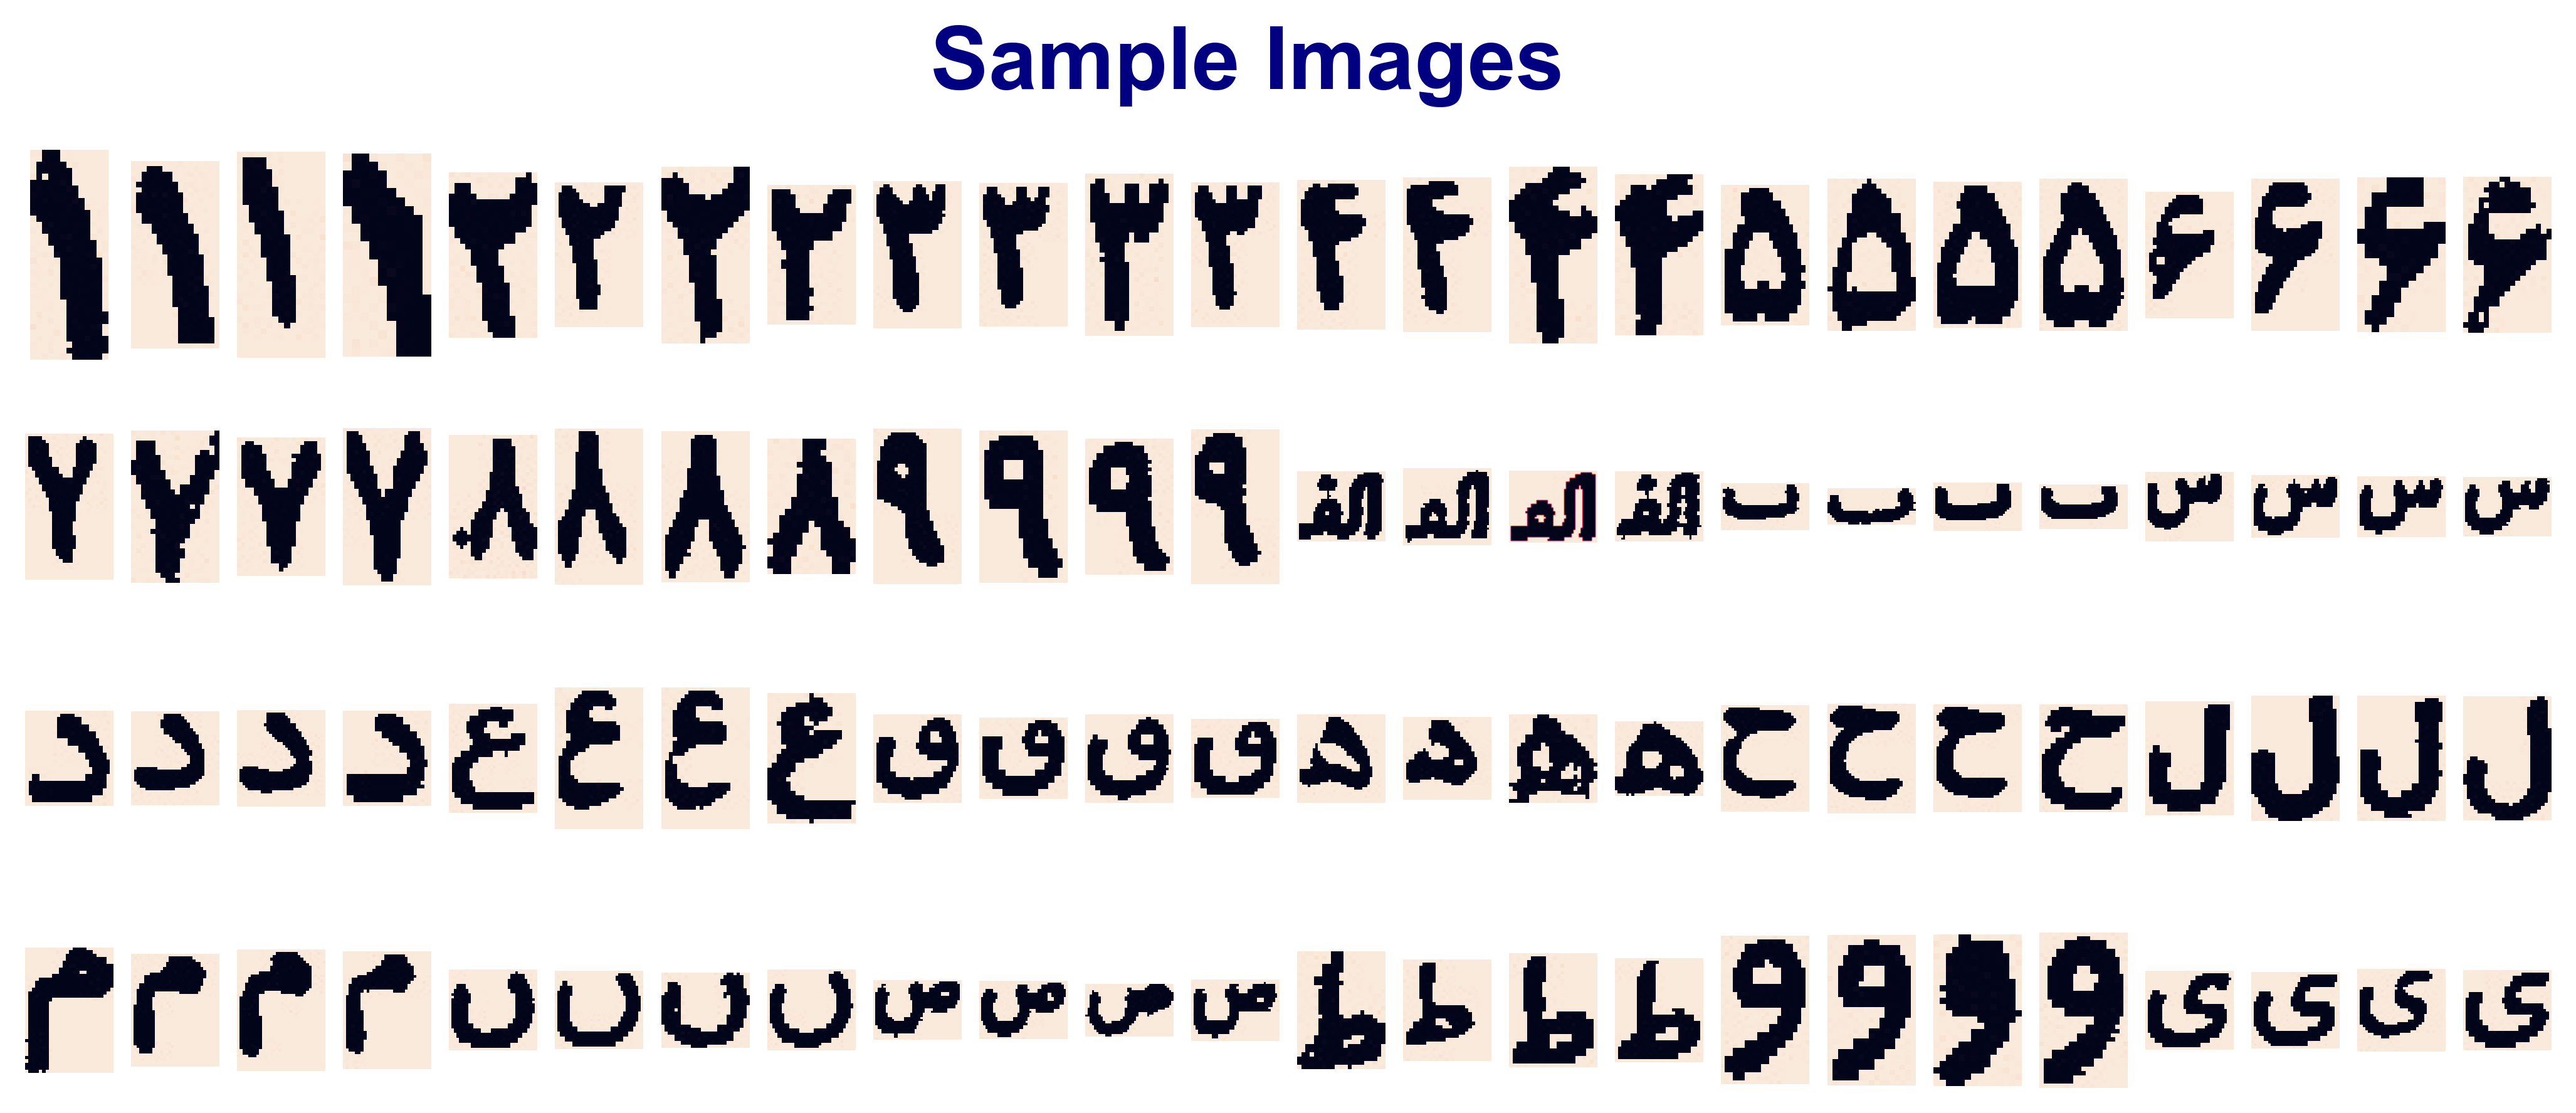

In [13]:
def Plot_Sample_Images() :
    all_images = []
    # alphabet_classes = os.listdir(alphabet_dir)

    for class_name in alphabet_classes :
        class_path = os.path.join(alphabet_dir, class_name)
        class_images = [os.path.join(class_path, file_name) for file_name in os.listdir(class_path)]
        random_images = random.choices(class_images, k=4)
        all_images.extend(random_images)
        
    plt.figure(figsize=(13, 5), dpi=400)
    plt.suptitle('Sample Images', fontsize=25, fontweight='bold', c='navy')
    for i in range(len(all_images)):
        plt.subplot(4, 24, i+1)
        img = plt.imread(all_images[i])
        plt.axis('off')
        plt.imshow(img)
    plt.show()

Plot_Sample_Images()

# Image_size

In [14]:
def Fetch_Image_Sizes() :
    '''
    A function to fetch all of images sizes and stored in a Set variable
    '''
    img_sizes = set()

    for class_name in tqdm(alphabet_classes) :
        class_path = os.path.join(alphabet_dir, class_name)
        class_files_path = [os.path.join(class_path, file_name) for file_name in os.listdir(class_path) if file_name.endswith('.jpg')]
        for image_path in class_files_path :
            img = cv2.imread(image_path)
            h, w, c = img.shape
            img_sizes.add((h, w, c))
    return img_sizes

img_sizes = Fetch_Image_Sizes()

100%|██████████| 24/24 [00:08<00:00,  2.93it/s]


In [15]:
if len(img_sizes) == 1 :
    print(f'There is a unique size of {img_sizes[0]} for all images.')
else :
    print(f'Tehre are {len(img_sizes)} different sizes for images.')

Tehre are 1147 different sizes for images.


In [16]:
min(img_sizes), max(img_sizes)

((8, 16, 3), (65, 40, 3))

In [17]:
h_mean = int(np.mean([min(img_sizes)[0], max(img_sizes)[0]]))
w_mean = int(np.mean([min(img_sizes)[1], max(img_sizes)[1]]))

img_size = (h_mean, w_mean)
print(f'Sellected size of images is mean of sizes, is {img_size}')

Sellected size of images is mean of sizes, is (36, 28)


# Split to train, valid, test

In [18]:
# Create a folder to store splited images
splited_alphabet = os.path.join(working_dir, 'splited_alphabet')

if not os.path.exists(splited_alphabet) :
    os.mkdir(splited_alphabet)

In [19]:
# splitfolders.ratio(
#     input=alphabet_dir,
#     output=splited_alphabet,
#     seed=42,
#     ratio=(0.6, 0.2, 0.2)
# )

In [20]:
def Count_images() :
    folders = os.listdir(splited_alphabet)
    print('Number of samples in each folder :')

    for folder in folders :
        count = 0
        folder_path = os.path.join(splited_alphabet, folder)
        for class_name in os.listdir(folder_path) :
            class_path = os.path.join(folder_path, class_name)
            count += len(os.listdir(class_path))
        print(f'{folder} : {count}')

Count_images()

Number of samples in each folder :
test : 4050
train : 27216
val : 4019


In [21]:
train_dir = os.path.join(splited_alphabet, 'train')
valid_dir = os.path.join(splited_alphabet, 'val')
test_dir = os.path.join(splited_alphabet, 'test')

# Augs = Blure, Add-Noise

In [22]:
def Blure_Filter(img, filter_type ="blur", kernel=3):
    '''
    ### Filtering ###
    img: image
    filter_type: {blur: blur, gaussian: gaussian, median: median}
    '''
    if filter_type == "blur":
        return cv2.blur(img,(kernel,kernel))
    
    elif filter_type == "gaussian":
        return cv2.GaussianBlur(img, (kernel, kernel), 0)
    
    elif filter_type == "median":
        return cv2.medianBlur(img, kernel)

In [23]:
def Add_Noise(img, noise_type="gauss"):
    '''
    ### Adding Noise ###
    img: image
    cj_type: {gauss: gaussian, sp: salt & pepper}
    '''
    if noise_type == "gauss": 
        mean=0
        st=0.5
        gauss = np.random.normal(mean,st,img.shape)
        gauss = gauss.astype('uint8')
        image = cv2.add(img,gauss)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        return image
    
    elif noise_type == "sp": 
        prob = 0.01
        black = np.array([0, 0, 0], dtype='uint8')
        white = np.array([255, 255, 255], dtype='uint8')

        probs = np.random.random(img.shape[:2])
        img[probs < (prob / 2)] = black
        img[probs > 1 - (prob / 2)] = white
        return img

In [24]:
sample_img = os.path.join(train_dir, 'char_H\\H_45339.jpg')
sample_img

'C:\\envs\\Working\\Iranian_Plates\\splited_alphabet\\train\\char_H\\H_45339.jpg'

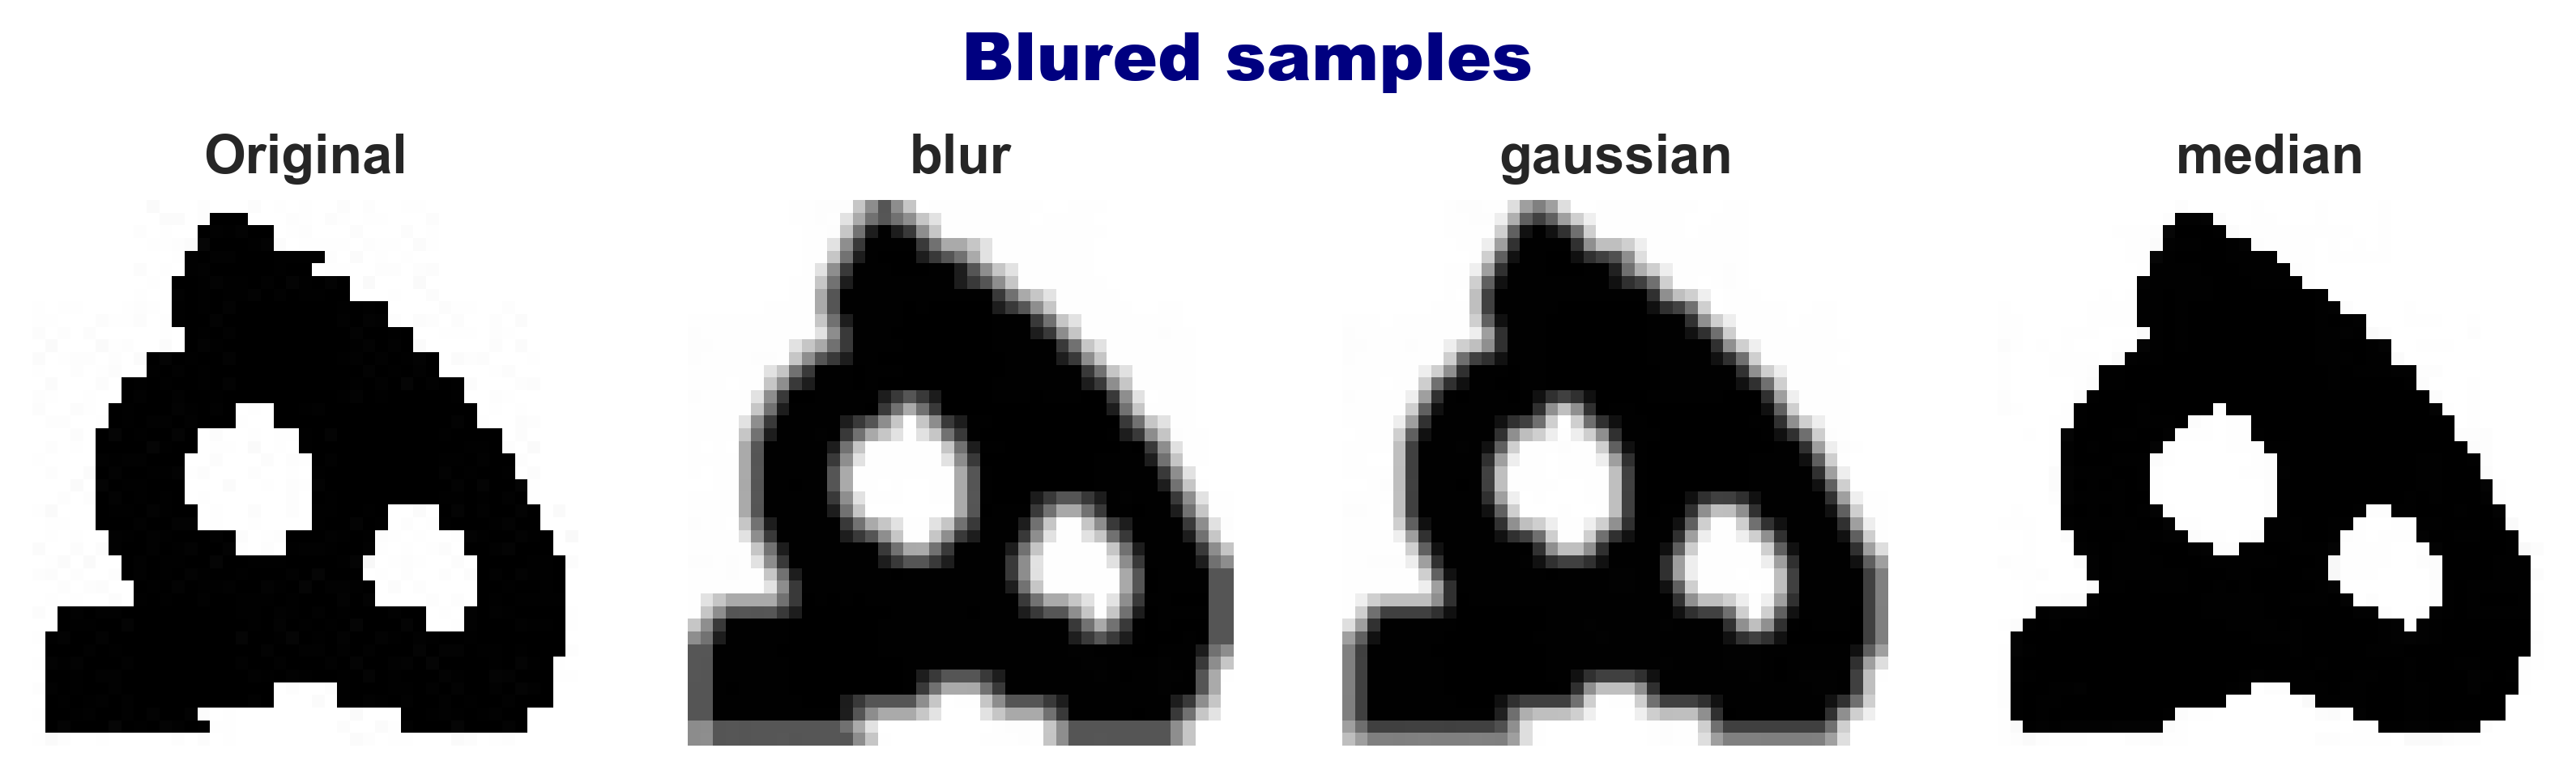

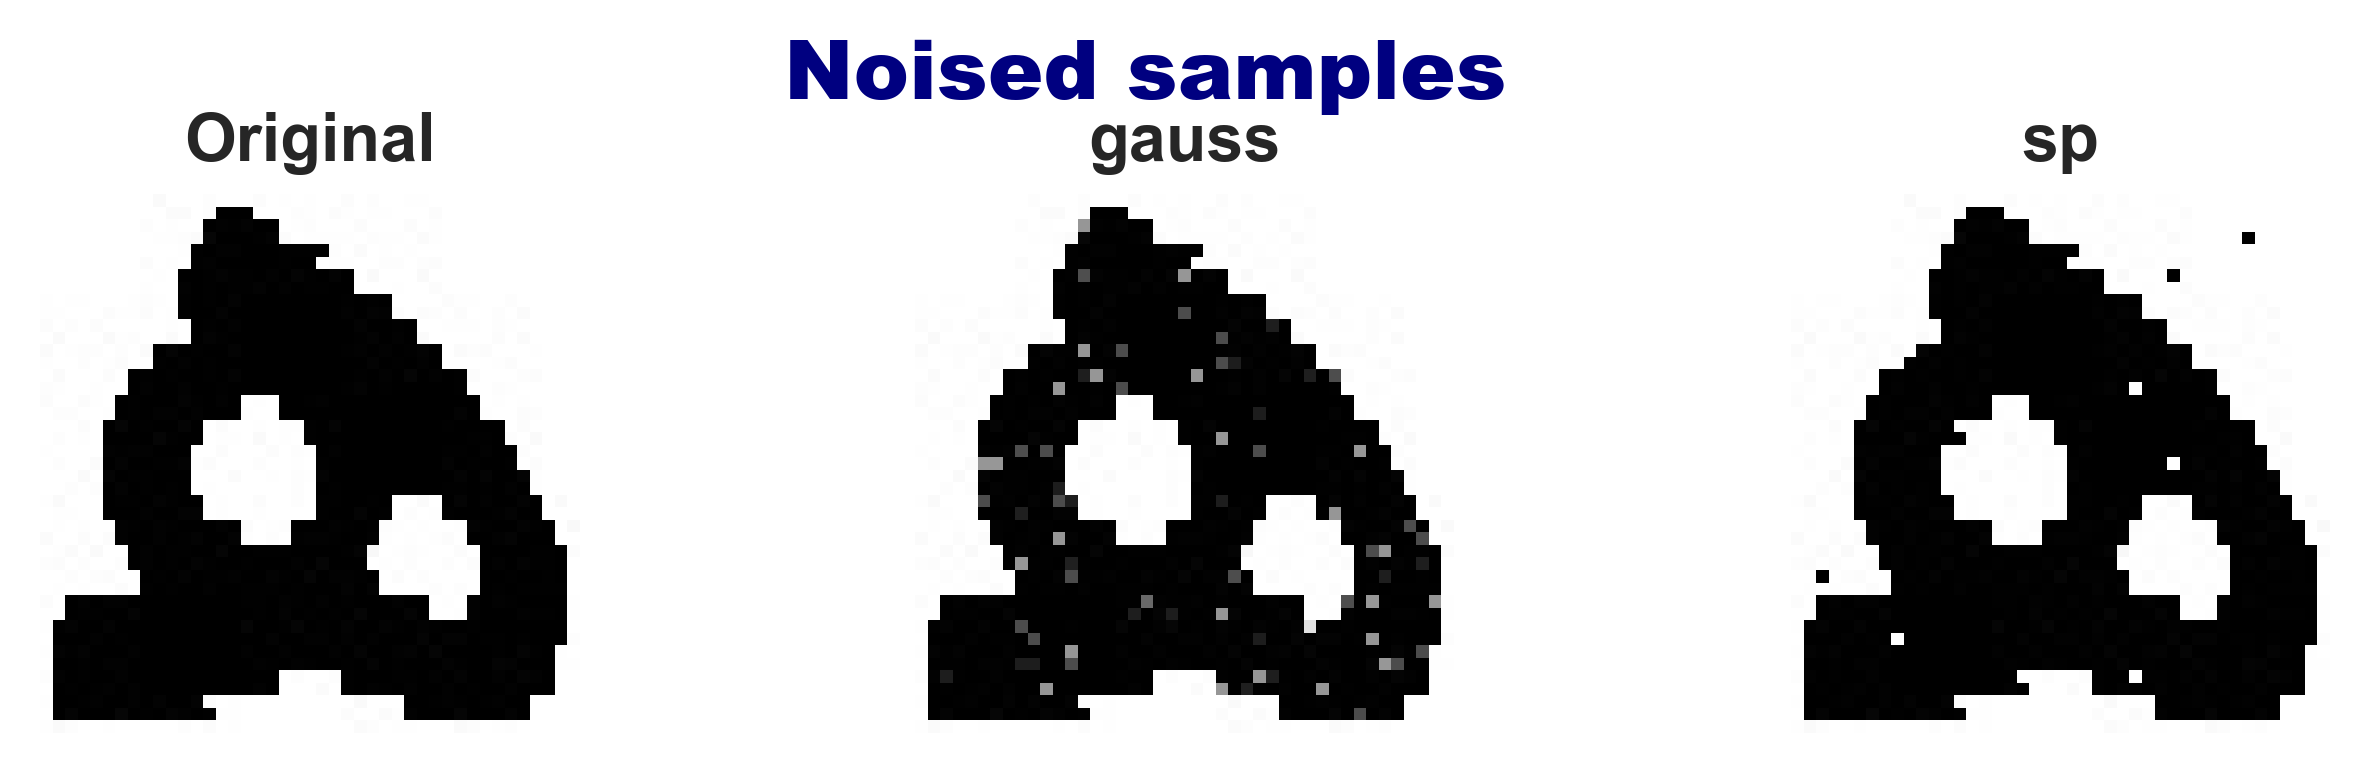

In [25]:
def Plot_AUGS_Samples():
    plt.figure(figsize=(10, 2.25), dpi=400)
    plt.suptitle('Blured samples', fontweight=900, fontsize=15, y=1.1, c='navy')
    # Original image
    plt.subplot(1, 4, 1)
    img = cv2.imread(sample_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Original', fontweight=800)
    # Blurs
    # List of filters
    filters = ['blur', 'gaussian', 'median']
    for filter in filters :
        indx = filters.index(filter)
        plt.subplot(1, 4, indx+2)
        filtered_img = Blure_Filter(img, filter_type=filter, kernel=3)
        plt.imshow(filtered_img)
        plt.axis('off')
        plt.title(filter, fontweight=800)

    plt.figure(figsize=(8,1.75), dpi=400)
    plt.suptitle('Noised samples', fontweight=900, fontsize=15, y=1.1, c='navy')
    plt.subplot(1, 3, 1)
    img = cv2.imread(sample_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Original', fontweight=800)

    noises = ['gauss', 'sp']
    for noise in noises :
        indx = noises.index(noise)
        plt.subplot(1, 3, indx+2)
        noised_img = Add_Noise(img, noise_type=noise)
        plt.imshow(noised_img, cmap='gray')
        plt.axis('off')
        plt.title(noise, fontweight=800)

Plot_AUGS_Samples()

In [26]:
def Augmentations(img) :
    ''' Apply random choice of augmentation functions on images '''

    returned_augs = dict()

    AUGS = ['Blure', 'Noise']

    # How many of Augs choosen ?
    random_num = random.randint(1, 2)
    random_choice = random.choices(AUGS, k=random_num)
    # To avoid repeatations :
    random_choice = list(set(random_choice))

    for choice in random_choice :
        if choice == 'Blure' :
            filters = ['blur', 'gaussian', 'median']
            kernel = 3
            random_filter = random.choices(filters, k=1)[0]
            blured_img =  Blure_Filter(img, filter_type=random_filter, kernel=kernel)
            new_name = '_blured'
            returned_augs[new_name] = blured_img


        elif choice == 'Noise' :
            noises = ['gauss', 'sp']
            random_noise = random.choices(noises, k=1)[0]
            noised_img = Add_Noise(img, noise_type=random_noise)
            new_name = '_noised'
            returned_augs[new_name] = noised_img
            
    return returned_augs

## apply aug to train_folder

In [27]:
def Count_Train_Images():
    '''
    A function to counts number of images in train folder
    '''
    num_images = 0

    for class_name in os.listdir(train_dir) :
        class_path = os.path.join(train_dir, class_name)
        num_images += len(os.listdir(class_path))
    
    return num_images

num_images_before_augs = Count_Train_Images()
print(f'Number of Train-images before Augmentations : {num_images_before_augs}')

Number of Train-images before Augmentations : 27216


In [28]:
# def Apply_Augmentations():
#     for class_name in os.listdir(train_dir) :
#         class_path = os.path.join(train_dir, class_name)
#         for file_name in tqdm(os.listdir(class_path)) :
#             img_path = os.path.join(class_path, file_name)
#             img = cv2.imread(img_path)
#             returned = Augmentations(img)

#             for exported_name, exported_image in returned.items() :
#                 # 1_left.jpg ---TO---> 1_lef_blured.jpg
#                 new_name = file_name.split('.')[0] + exported_name + '.' + file_name.split('.')[-1]
#                 new_path = os.path.join(class_path, new_name)
            
#                 # Save new image
#                 cv2.imwrite(new_path, exported_image) 

# Apply_Augmentations()

In [29]:
num_images_after_augs = Count_Train_Images()
print(f'Number of Train-images before Augmentations : {num_images_after_augs}')

Number of Train-images before Augmentations : 27216


In [30]:
print(f'{num_images_after_augs - num_images_before_augs} images added by Data-Augmentations')

0 images added by Data-Augmentations


# DataSets and DataLoaders

In [31]:
batch_size = 64

In [93]:
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor()
])

In [33]:
############################| Train |############################
# Create Dataset from Images
train_ds = ImageFolder(root=train_dir, transform=transform)

# Create DataLoader from defined dataset
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

print('Train Dataset\n')
print(train_ds)
print()
print('Train DataLoader\n')
print(train_loader)
print('_'*100)
############################| Validation |############################
# Create Dataset from Images
valid_ds = ImageFolder(root=valid_dir, transform=transform)

# Create DataLoader from defined dataset
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

print('Validation Dataset\n')
print(valid_ds)
print()
print('Validation DataLoader\n')
print(valid_loader)
print('_'*100)
############################| Test |############################
# Create Dataset from Images
test_ds = ImageFolder(root=test_dir, transform=transform)

# Create DataLoader from defined dataset
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

print('Test Dataset\n')
print(test_ds)
print()
print('Test DataLoader\n')
print(test_loader)
print('_'*100)

Train Dataset

Dataset ImageFolder
    Number of datapoints: 27216
    Root location: C:\envs\Working\Iranian_Plates\splited_alphabet\train
    StandardTransform
Transform: Compose(
               Resize(size=(36, 28), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

Train DataLoader

____________________________________________________________________________________________________
Validation Dataset

Dataset ImageFolder
    Number of datapoints: 4019
    Root location: C:\envs\Working\Iranian_Plates\splited_alphabet\val
    StandardTransform
Transform: Compose(
               Resize(size=(36, 28), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

Validation DataLoader

____________________________________________________________________________________________________
Test Dataset

Dataset ImageFolder
    Number of datapoints: 4050
    Root location: C:\envs\Working\Iranian_Plates\splited_alph

In [34]:
# print shape of dataset for each set
for key, value in {'Train': train_loader, "Validation": valid_loader, 'Test': test_loader}.items():
    for X, y in value:
        print(colored(f'{key}:', 'white','on_green', attrs=['bold']))
        print(f"Shape of images [Batch_size, Channels, Height, Width]: {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        print('-'*45)
        break

Train:
Shape of images [Batch_size, Channels, Height, Width]: torch.Size([64, 3, 36, 28])
Shape of y: torch.Size([64]) torch.int64

---------------------------------------------
Validation:
Shape of images [Batch_size, Channels, Height, Width]: torch.Size([64, 3, 36, 28])
Shape of y: torch.Size([64]) torch.int64

---------------------------------------------
Test:
Shape of images [Batch_size, Channels, Height, Width]: torch.Size([64, 3, 36, 28])
Shape of y: torch.Size([64]) torch.int64

---------------------------------------------


# Space Freeup

In [35]:
del [alphabet_base, alphabet_dir, ax, container, img_sizes, h_mean, w_mean, splited_alphabet, train_dir, valid_dir, test_dir, sample_img, num_images_before_augs, num_images_after_augs, transform]

In [126]:
gc.collect()

32755

In [127]:
torch.cuda.empty_cache()

# Model

In [129]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if device.type == 'cuda' :
    print('GPU is available.')
else :
    print('You are using CPU !')

GPU is available.


In [130]:
eff_model = googlenet(weights=GoogLeNet_Weights)
# eff_model = efficientnet_b5(weights=EfficientNet_B5_Weights)
eff_model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [131]:
eff_model.fc = nn.Sequential(
    nn.Dropout(p=0.4, inplace=True),
    nn.Linear(in_features=1024, out_features=512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(in_features=512, out_features=128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(in_features=128, out_features=len(alphabet_classes))
)

In [132]:
eff_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [133]:
def DeltaTime(dt) :
    '''A Function to apply strftime manualy on delta.datetime class'''
    h = dt.seconds // 3600
    dh = dt.seconds % 3600

    m = dh // 60
    s = dh % 60

    if h<10 : h='0'+str(h)
    else : h = str(h)

    if m<10 : m='0'+str(m)
    else : m = str(m)

    if s<10 : s='0'+str(s)
    else : s = str(s)

    return( h + ':' + m + ':' + s)

In [134]:
def Beauty_epoch(epoch) :
    ''' Return epochs in 2 digits - like (01 or 08) '''
    if epoch<10 :
        return '0' + str(epoch)
    else :
        return str(epoch)

In [135]:
def Save_Best_Weight(val_loss) :
    best_loss_save = 0
    if val_loss > best_loss_save :
        best_loss_save = val_loss
        torch.save(eff_model, 'Best_weight.pt')

In [136]:
num_epochs = 20

In [46]:
# Create Loss_function and Optimizer
Learning_Rate = 0.01

# criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(eff_model.parameters(), lr=Learning_Rate)

# Some variables to store loss and accuracy to plot them
train_losses = np.zeros(num_epochs)
train_accs = np.zeros(num_epochs)
valid_losses = np.zeros(num_epochs)
valid_accs = np.zeros(num_epochs)

print(colored('Training Starts ... ', 'blue', 'on_white', attrs=['bold']))
for epoch in range(num_epochs) :

    # criterion = nn.CrossEntropyLoss()
    # optimizer = torch.optim.Adam(eff_model.parameters(), lr=Learning_Rate)
    
    # Set the mode to TRAIN
    eff_model.train()

    # Current time to calculate duration of epoch
    t0 = datetime.now()

    # Some variables to store data
    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []
    n_correct = 0
    n_total = 0

            ###############
            #### Train ####
            ###############

    # Read Images and Labels from TrainLoader
    for images, labels in train_loader :
        # Move Data to GPU
        images = images.to(device)
        labels = labels.to(device)

        # Reshape labels to [Batch-Size, 1]
        # labels = torch.reshape(labels, (-1, 1))

        # Zero Grad Optimizer
        optimizer.zero_grad()

        # Forward Pass
        y_pred = eff_model(images)
        loss = criterion(y_pred, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Train Loss
        train_loss.append(loss.item())

        # Train Accuracy
        _, prediction = torch.max(y_pred, 1)
        n_correct += (prediction==labels).sum().item()
        n_total += labels.shape[0]

    train_losses[epoch] = np.mean(train_loss)
    train_accs[epoch] = n_correct / n_total

            ####################
            #### Validation ####
            ####################

    n_correct = 0
    n_total = 0

    # Read Images and Labels from ValidLoader
    for images, labels in valid_loader :
        # Move Data to GPU
        images = images.to(device)
        labels = labels.to(device)

        # Reshape labels to [Batch-Size, 1]
        # labels = torch.reshape(labels, (-1, 1))

        # Forward pass
        y_pred = eff_model(images)
        loss = criterion(y_pred, labels)

        # Validation Loss
        valid_loss.append(loss.item())

        # val Accuracy
        _, prediction = torch.max(y_pred, 1)
        n_correct += (prediction==labels).sum().item()
        n_total += labels.shape[0]
    
    valid_losses[epoch] = np.mean(valid_loss)
    valid_accs[epoch] = n_correct / n_total

    Save_Best_Weight(valid_losses[epoch])

    ############################### Duration ###############################

    dt = datetime.now() - t0

    ############################### BEAUTIFULL OUTPUT ###############################
    EPOCH =  colored(f' Epoch [{Beauty_epoch(epoch+1)}/{num_epochs}] ', 'black', 'on_white', attrs=['bold'])
    TRAIN_LOSS = colored(f' Train Loss:{train_losses[epoch]:.4f} ', 'white', 'on_green', attrs=['bold'])
    TRAIN_ACC = colored(f' Train Acc:{train_accs[epoch]:.4f} ', 'white', 'on_blue', attrs=['bold'])
    VAL_LOSS = colored(f' Val Loss:{valid_losses[epoch]:.4f} ', 'white', 'on_green', attrs=['bold'])
    VAL_ACC = colored(f' Val Acc:{valid_accs[epoch]:.4f} ', 'white', 'on_blue', attrs=['bold'])
    DURATION = colored(f' Duration : {DeltaTime(dt)} ', 'white', 'on_dark_grey', attrs=['bold'])
    LR = colored(f' lr = {Learning_Rate} ', 'black',  'on_cyan', attrs=['bold'])

    ###################################### CallBacks ######################################

    if epoch > 4 :
        temp_valid_losses = valid_losses[: epoch]
        if temp_valid_losses[-1] > temp_valid_losses[-2] > temp_valid_losses[-3] :
            Learning_Rate /= 10


    # Print the result of  each epochs
    print(f'{EPOCH} -> {TRAIN_LOSS}{TRAIN_ACC} {VAL_LOSS}{VAL_ACC} {DURATION} {LR}')


print(colored('Training Finished ...', 'blue', 'on_white', attrs=['bold']))

Training Starts ... 
 Epoch [01/20]  ->  Train Loss:2.0114  Train Acc:0.3291   Val Loss:1.4772  Val Acc:0.4932   Duration : 00:00:39   lr = 0.01 
 Epoch [02/20]  ->  Train Loss:1.6161  Train Acc:0.5005   Val Loss:1.1064  Val Acc:0.5631   Duration : 00:00:30   lr = 0.01 
 Epoch [03/20]  ->  Train Loss:0.9640  Train Acc:0.6296   Val Loss:0.7168  Val Acc:0.7066   Duration : 00:00:30   lr = 0.01 
 Epoch [04/20]  ->  Train Loss:1.0498  Train Acc:0.6219   Val Loss:1.0068  Val Acc:0.6151   Duration : 00:00:31   lr = 0.01 
 Epoch [05/20]  ->  Train Loss:0.9008  Train Acc:0.6646   Val Loss:0.9056  Val Acc:0.6723   Duration : 00:00:31   lr = 0.01 
 Epoch [06/20]  ->  Train Loss:0.6694  Train Acc:0.7474   Val Loss:0.5085  Val Acc:0.8129   Duration : 00:00:30   lr = 0.01 
 Epoch [07/20]  ->  Train Loss:0.7696  Train Acc:0.7476   Val Loss:0.6436  Val Acc:0.7499   Duration : 00:00:30   lr = 0.01 
 Epoch [08/20]  ->  Train Loss:0.6526  Train Acc:0.7781   Val Loss:0.5356  Val Acc:0.8097   Duration : 0

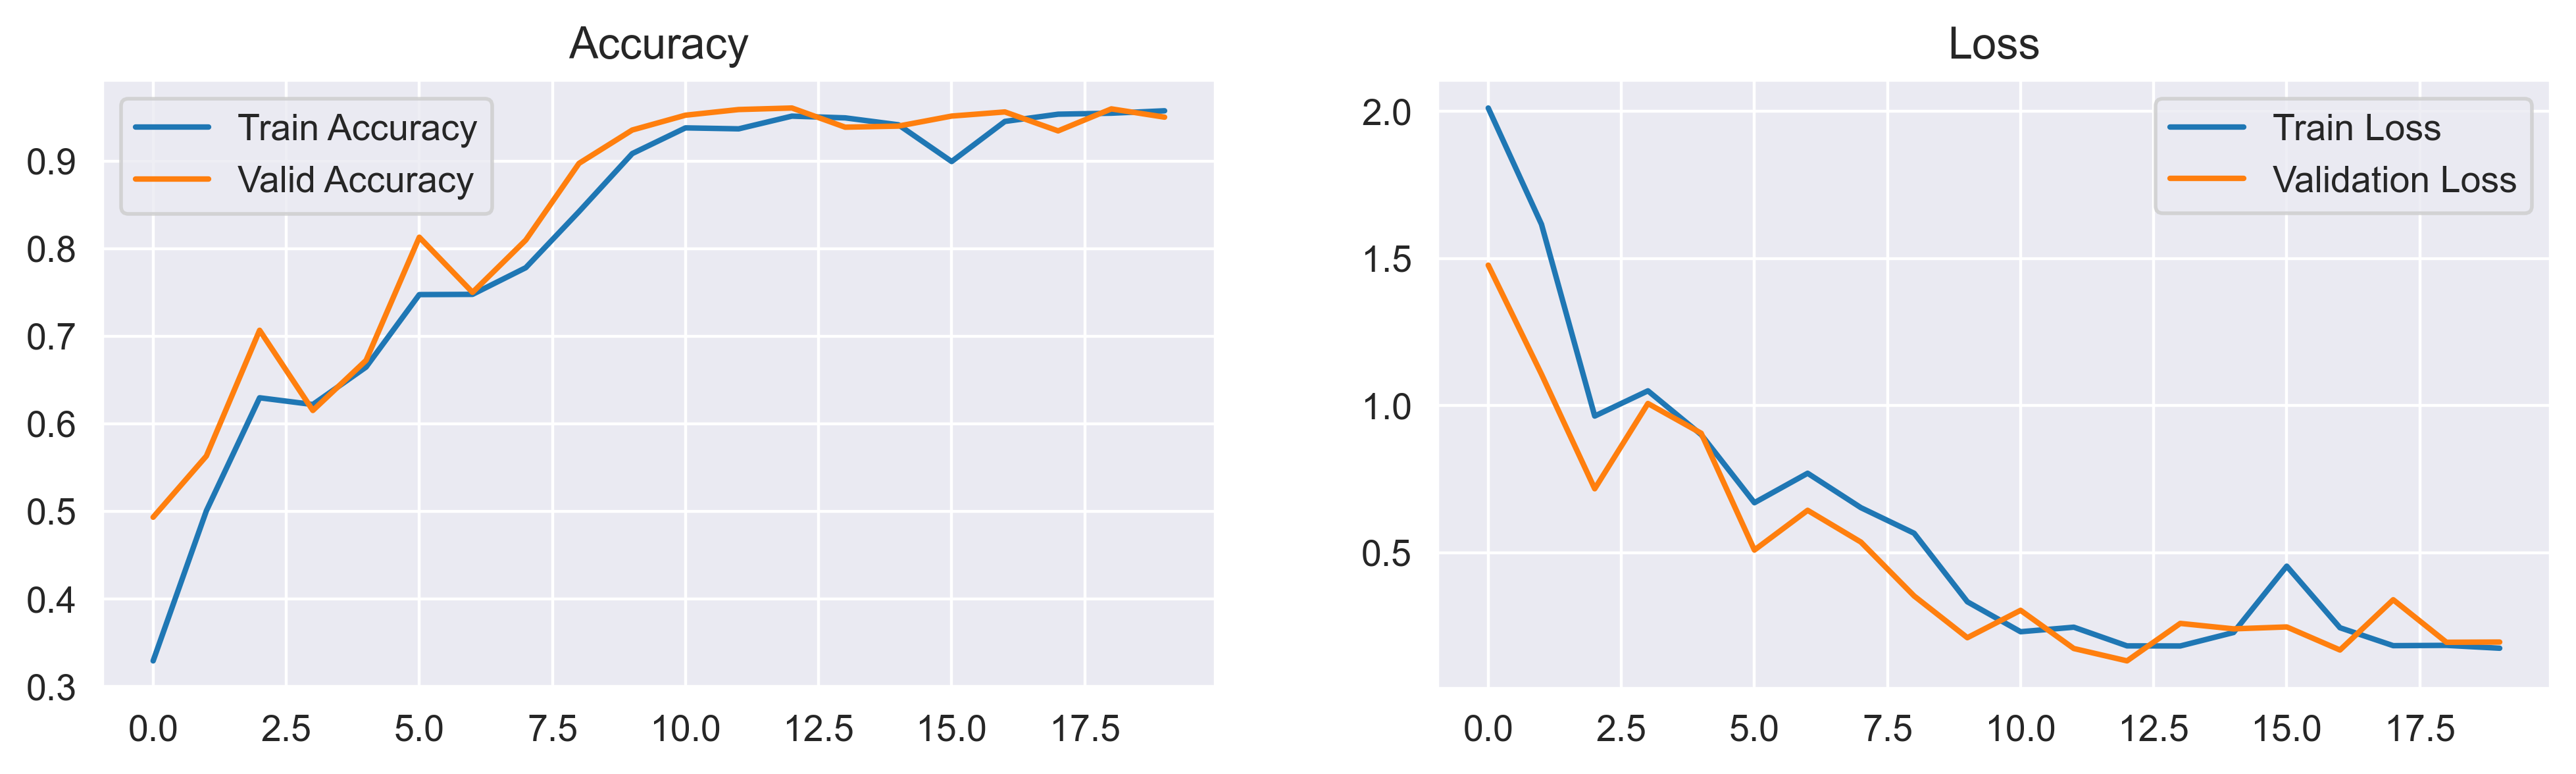

In [47]:
plt.figure(figsize=(12, 3), dpi=400)
plt.subplot(1, 2, 1)
sns.lineplot(train_accs, label='Train Accuracy')
sns.lineplot(valid_accs, label='Valid Accuracy')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(train_losses, label='Train Loss')
sns.lineplot(valid_losses, label='Validation Loss')
plt.title('Loss')

plt.show()

In [48]:
best_eff_model = torch.load('Best_weight.pt')

In [49]:
best_eff_model = best_eff_model.to(device)
with torch.no_grad() :
    best_eff_model.eval()
    t0 = datetime.now()
    test_loss = []
    val_loss = []
    n_correct = 0
    n_total = 0

    for images, labels in test_loader :
        # Move input data to GPU
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        y_pred = best_eff_model(images)
        loss = criterion(y_pred, labels)

        # Train Loss
        test_loss.append(loss.item())

        # Train Accuracy
        _, prediction = torch.max(y_pred, 1)
        n_correct += (prediction==labels).sum().item()
        n_total += labels.shape[0]

    test_loss = np.mean(train_loss)
    train_acc = n_correct / n_total
    dt = datetime.now() - t0
    print(colored(f'Loss:{test_loss:.4f}\nAccuracy:{train_acc:.4f}\nDuration:{dt}', 'green', attrs=['bold']))

Loss:0.1746
Accuracy:0.9825
Duration:0:00:03.759840


In [50]:
# Create a label_map to show True and Predicted labels in below plot
alphabet_classes.sort()

labels_map = {}

for index, label in enumerate(alphabet_classes) :
    labels_map[index] = label

labels_map

{0: 'char_1',
 1: 'char_2',
 2: 'char_3',
 3: 'char_4',
 4: 'char_5',
 5: 'char_6',
 6: 'char_7',
 7: 'char_8',
 8: 'char_9',
 9: 'char_A',
 10: 'char_B',
 11: 'char_C',
 12: 'char_D',
 13: 'char_E',
 14: 'char_G',
 15: 'char_H',
 16: 'char_J',
 17: 'char_L',
 18: 'char_M',
 19: 'char_N',
 20: 'char_S',
 21: 'char_T',
 22: 'char_V',
 23: 'char_Y'}

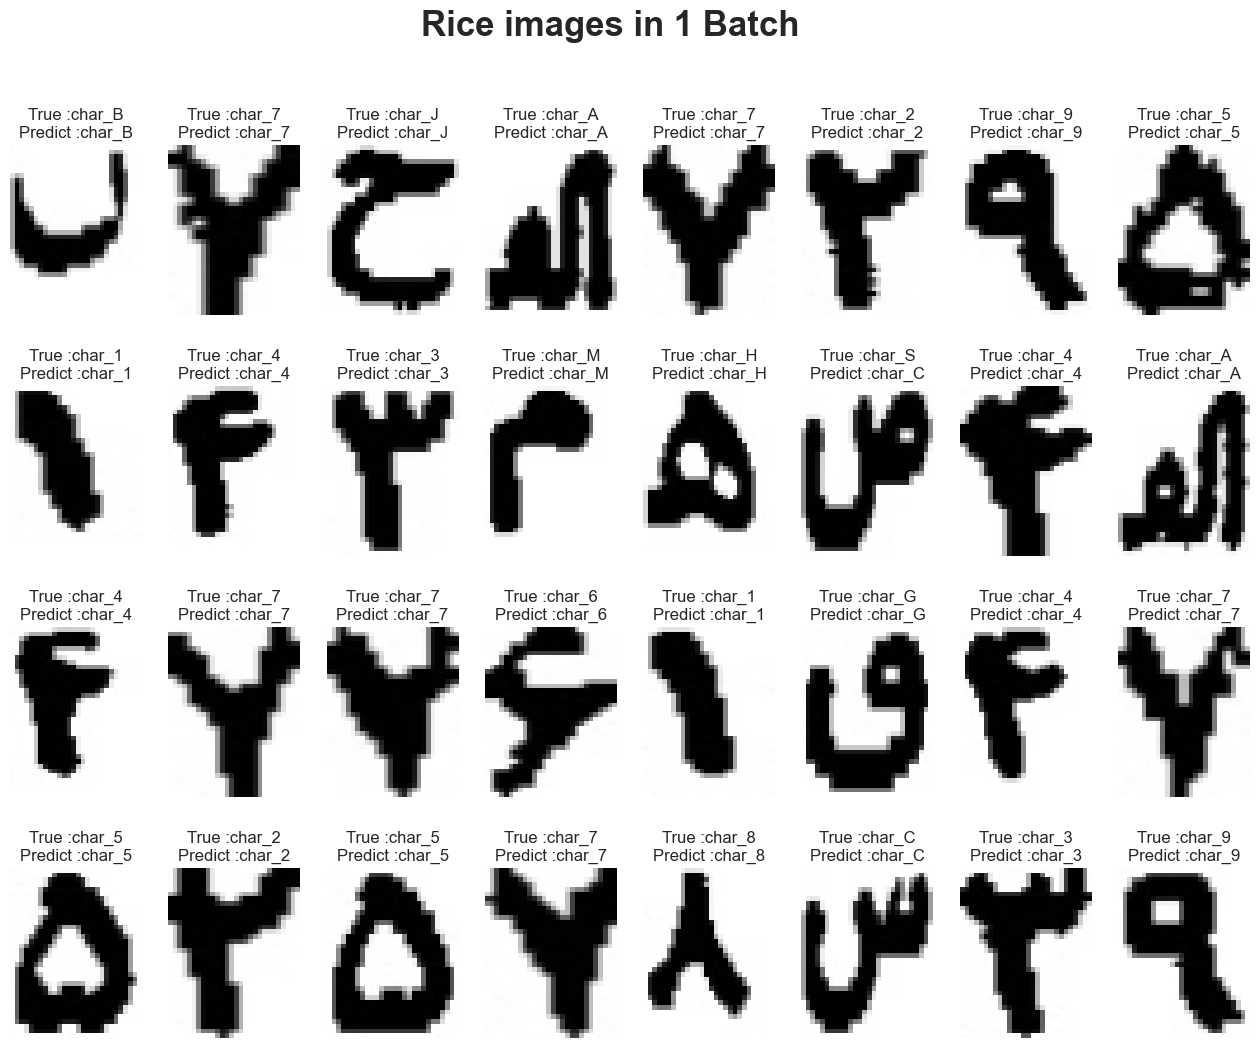

In [51]:
# Move model to CPU
cpu_eff_model = best_eff_model.cpu()

# Get 1 batch of test_loader
for imgs, labels in test_loader :
    break

# Plot 1 batch of test_loader images with True and Predicted label
plt.subplots(4, 8, figsize=(16, 12))
plt.suptitle('Rice images in 1 Batch', fontsize=25, fontweight='bold')
for i in range(32) :
    ax = plt.subplot(4, 8, i+1)
    img = torch.permute(imgs[i], (1, 2, 0))
    plt.imshow(img)
    label = labels_map[int(labels[i])]
    img = img[i].unsqueeze(0)
    img = imgs[i].unsqueeze(0)
    out = cpu_eff_model(img)
    predict = labels_map[int(out.argmax())]
    plt.title(f'True :{label}\nPredict :{predict}')
    plt.axis('off')

plt.show()

In [52]:
# Get out 2 list include y_true and y_pred for use in confusion_matrix
best_eff_model = best_eff_model.to(device)

y_true = []
y_pred = []
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.numpy()
    outputs = best_eff_model(images)
    _, pred = torch.max(outputs.data, 1)
    pred = pred.detach().cpu().numpy()
    
    y_true = np.append(y_true, labels)
    y_pred = np.append(y_pred, pred)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       256
         1.0       1.00      0.99      1.00       308
         2.0       1.00      1.00      1.00       273
         3.0       1.00      1.00      1.00       275
         4.0       0.98      0.99      0.99       366
         5.0       1.00      0.98      0.99       397
         6.0       1.00      1.00      1.00       318
         7.0       1.00      0.98      0.99       295
         8.0       1.00      1.00      1.00       274
         9.0       1.00      1.00      1.00       192
        10.0       1.00      1.00      1.00       178
        11.0       0.65      1.00      0.79        79
        12.0       1.00      1.00      1.00       100
        13.0       0.89      0.97      0.93        34
        14.0       0.92      1.00      0.96        98
        15.0       0.98      1.00      0.99        44
        16.0       1.00      1.00      1.00       116
        17.0       0.96    

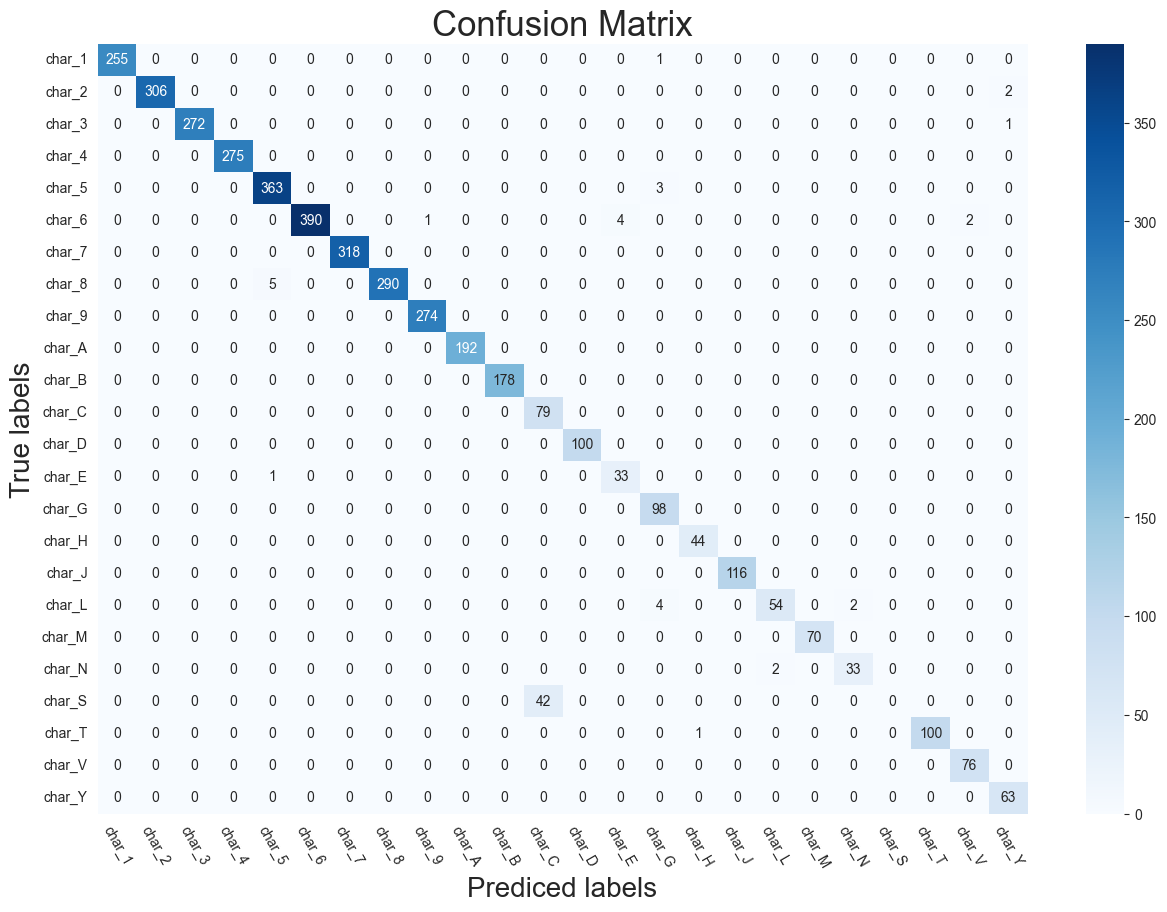

In [53]:
classes = labels_map.values()

print(classification_report(y_true, y_pred))

def plot_confusion_matrix(y_test, y_prediction):
    '''Plotting Confusion Matrix'''
    cm = confusion_matrix(y_true, y_pred)
    ax = plt.figure(figsize=(15, 10))
    ax = sns.heatmap(cm, annot=True, fmt='', cmap="Blues")
    ax.set_xlabel('Prediced labels', fontsize=20)
    ax.set_ylabel('True labels', fontsize=20)
    ax.set_title('Confusion Matrix', fontsize=25)
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes) 
    plt.xticks(rotation=-60)
    plt.yticks(rotation=0)
    plt.show()


plot_confusion_matrix(y_true, y_pred)

_____________________________________________________________________________________________________________________________________________________________________

# Phase 02  - Plate Detection with Ultralytitcs

_____________________________________________________________________________________________________________________________________________________________________

# Data Loading

In [54]:
base_dir = 'C:\\envs\\DataSets\\Persian Car Plates.v2i.yolov8-obb'

# Path of yaml file
yaml_path = os.path.join(base_dir, 'data.yaml')

# Path of Train directory
train_dir = os.path.join(base_dir, 'train')
train_images = os.path.join(train_dir, 'images')
train_labels = os.path.join(train_dir, 'labels')

# Path of Validation directory
valid_dir = os.path.join(base_dir, 'valid')
valid_images = os.path.join(valid_dir, 'images')

# Path of Test directory
test_dir = os.path.join(base_dir, 'test')
test_images = os.path.join(test_dir, 'images')

In [55]:
print(colored(f' Number of Train Images : {len(os.listdir(train_images))} ', 'blue', 'on_white', attrs=['bold']))
print(colored(f' Number of Validation Images : {len(os.listdir(valid_images))}', 'blue', 'on_white',  attrs=['bold']))
print(colored(f' Number of Test Images : {len(os.listdir(test_images))} ', 'blue', 'on_white',  attrs=['bold']))
print('_'*70)
print(colored(f' Number of All Images : {len(os.listdir(train_images)) + len(os.listdir(valid_images)) + len(os.listdir(test_images))} ', 'green', 'on_white',  attrs=['bold']))

 Number of Train Images : 219 
 Number of Validation Images : 63
 Number of Test Images : 31 
______________________________________________________________________
 Number of All Images : 313 


# Image Sizes

In [56]:
def Image_Size(train_images) :
    img_sizes = set()

    for img_name in tqdm(os.listdir(train_images)) :
        img_path = os.path.join(train_images, img_name)
        img = cv2.imread(img_path)
        h, w, c = img.shape
        img_sizes.add((h, w))

    return img_sizes

img_sizes = Image_Size(train_images)

if len(img_sizes) == 1 :
    print(f'All the images have size of {img_sizes}')
else :
    print(f'There are {len(img_sizes)} different image sizes !')


100%|██████████| 219/219 [00:01<00:00, 207.61it/s]

All the images have size of {(640, 640)}


In [57]:
img_size = (640, 640)
H = img_size[0]
W = img_size[1]

# Plot Random Images With BBOXs

In [58]:
def TXT_To_BBOX(lbl_path) :
    bbox = open(lbl_path, 'r')
    bbox = bbox.read()
    bbox = bbox.split(' ')[1:]

    p1 = [int(float(bbox[0])*H), int(float(bbox[1])*W)]
    p2 = [int(float(bbox[2])*H), int(float(bbox[3])*W)]
    p3 = [int(float(bbox[4])*H), int(float(bbox[5])*W)]
    p4 = [int(float(bbox[6])*H), int(float(bbox[7])*W)]

    pts = np.array([p1, p2, p3, p4], np.int32)
    pts = pts.reshape((-1, 1, 2))
    return pts

In [59]:
def JPG_Name_To_TXT(img_name) :
    name = img_name.split('.')[:-1]
    name = '.'.join(name)
    txt_name = name + '.txt'
    return txt_name

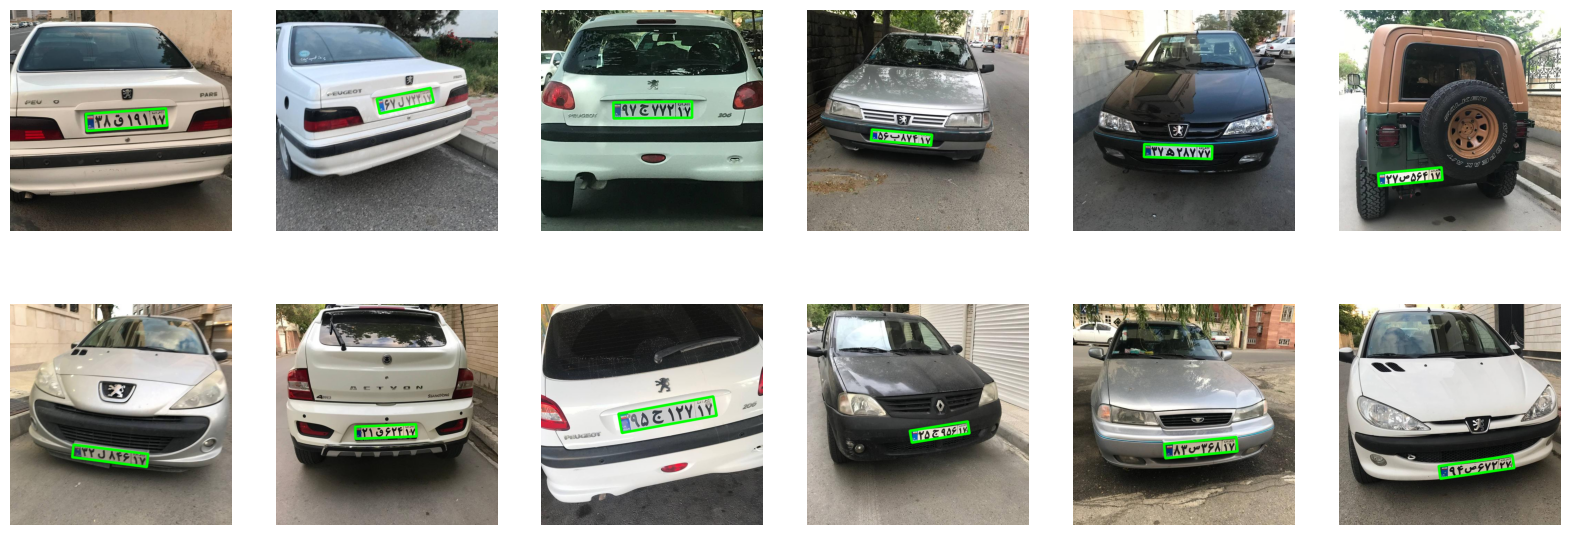

In [60]:
def Plot_Random_Images() :
    random_images = random.choices(os.listdir(train_images), k=12)
    i = 1
    plt.figure(figsize=(20, 7))
    for img_name in random_images :
        plt.subplot(2, 6, i)
        # Image
        img_path = os.path.join(train_images, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # BBox
        txt_name = JPG_Name_To_TXT(img_name)
        lbl_path = os.path.join(train_labels, txt_name)
        pts = TXT_To_BBOX(lbl_path)
        cv2.polylines(img, [pts], True, (0, 255, 0), 5, cv2.LINE_AA)

        plt.imshow(img)
        plt.axis('off')
        i += 1
Plot_Random_Images()

# Model

In [61]:
yolo_model = YOLO('yolov8n.yaml').load('yolov8n.pt')

result = yolo_model.train(data=yaml_path, epochs=20, amp=False)

Transferred 355/355 items from pretrained weights
Ultralytics YOLOv8.2.48  Python-3.11.7 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.yaml, data=C:\envs\DataSets\Persian Car Plates.v2i.yolov8-obb\data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_

train: Scanning C:\envs\DataSets\Persian Car Plates.v2i.yolov8-obb\train\labels.cache... 219 images, 0 backgrounds, 0 corrupt: 100%|██████████| 219/219 [00:00<?, ?it/s]
val: Scanning C:\envs\DataSets\Persian Car Plates.v2i.yolov8-obb\valid\labels.cache... 63 images, 0 backgrounds, 0 corrupt: 100%|██████████| 63/63 [00:00<?, ?it/s]


Plotting labels to runs\detect\train5\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train5
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.83G      1.176      3.132      1.213         23        640: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all         63         63    0.00333          1      0.871      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.87G     0.8821      1.687     0.9046         17        640: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         63         63    0.00328      0.984      0.827       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.83G     0.8744      1.448     0.9549         18        640: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all         63         63    0.00328      0.984      0.964      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.83G     0.8771      1.355     0.9252         20        640: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all         63         63          1      0.151      0.843      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.84G     0.8517      1.298     0.9504         18        640: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all         63         63      0.977      0.676      0.927      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.87G     0.8641      1.241     0.9556         22        640: 100%|██████████| 14/14 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         63         63      0.946      0.952      0.981       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.84G     0.7927      1.153     0.9405         16        640: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         63         63      0.978      0.952      0.983      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.84G     0.7501      1.029     0.9094         21        640: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         63         63      0.966      0.952      0.972      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.84G     0.7427     0.9991     0.9351         19        640: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         63         63      0.968      0.968      0.987      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.84G       0.71     0.9149     0.9225         13        640: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         63         63      0.977      0.921      0.978      0.831


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.84G     0.6356      1.073     0.8918         11        640: 100%|██████████| 14/14 [00:09<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         63         63      0.969      0.998      0.994      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.84G     0.6238      1.007     0.9032         11        640: 100%|██████████| 14/14 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         63         63      0.983      0.984      0.992      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.84G     0.5951      0.932     0.8853         11        640: 100%|██████████| 14/14 [00:08<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all         63         63      0.984      0.983      0.987      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.84G     0.5892     0.8651     0.8735         11        640: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         63         63      0.983      0.984      0.994      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.84G     0.5907     0.8598     0.8905         11        640: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         63         63      0.982      0.984      0.988      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.84G     0.5569      0.815     0.8721         11        640: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         63         63      0.982      0.984      0.989      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.84G     0.4726     0.7555     0.8315         11        640: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         63         63      0.984      0.981      0.989      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.84G     0.4707     0.7392     0.8284         11        640: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all         63         63      0.984      0.983      0.989      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.84G     0.4583     0.7201     0.8441         11        640: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         63         63      0.984      0.984       0.99       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.84G     0.4284      0.684     0.8231         11        640: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all         63         63      0.984      0.984      0.992      0.919



20 epochs completed in 0.069 hours.
Optimizer stripped from runs\detect\train5\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train5\weights\best.pt, 6.2MB

Validating runs\detect\train5\weights\best.pt...
Ultralytics YOLOv8.2.48  Python-3.11.7 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 4096MiB)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


                   all         63         63      0.984      0.984      0.992      0.919
Speed: 0.4ms preprocess, 18.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\detect\train5


In [62]:
# Location of stored result
result_path = result.save_dir

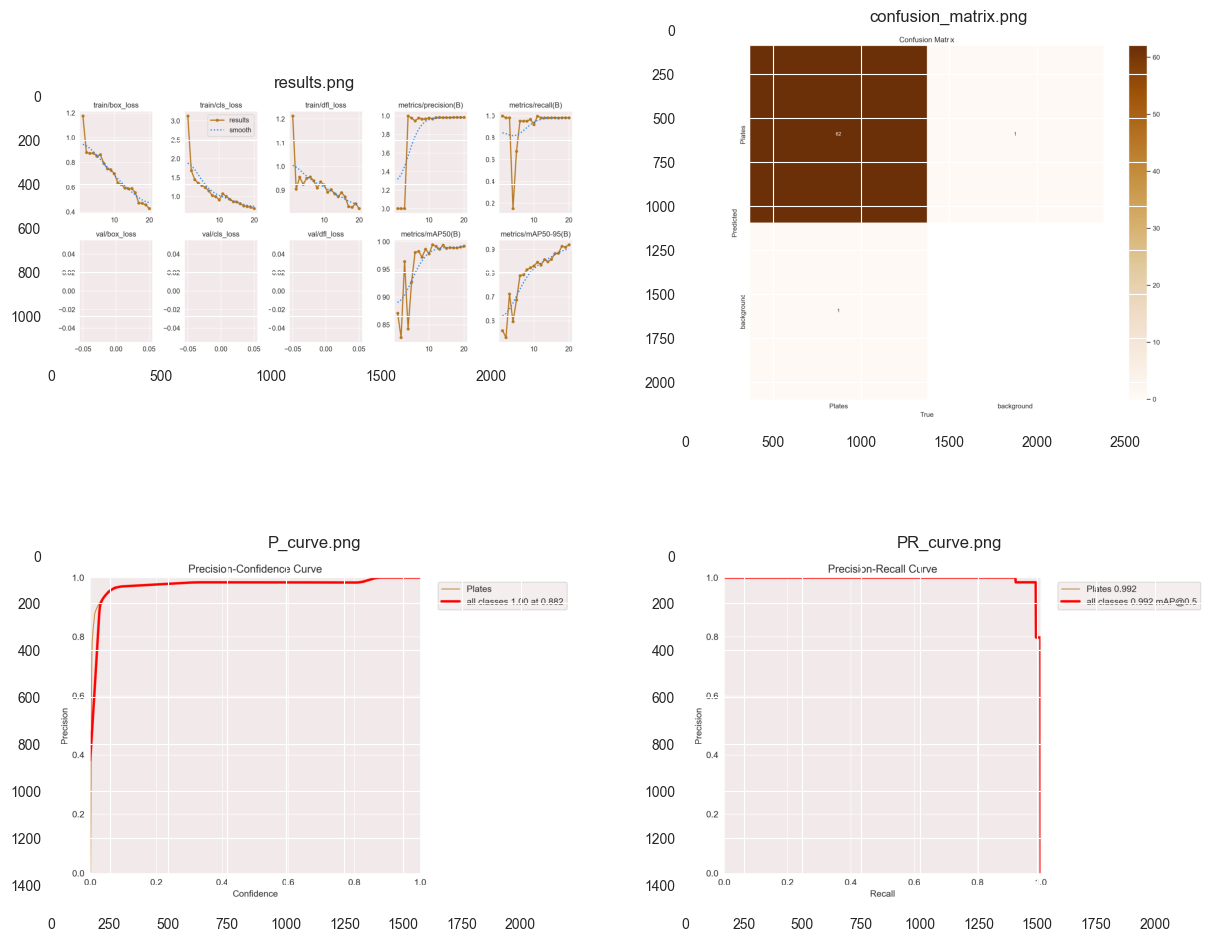

In [63]:
# List of some metrics
metrics = ['results.png','confusion_matrix.png', 'P_curve.png', 'PR_curve.png']

plt.figure(figsize=(15, 12))
i = 1

for image_name in metrics:
    image_path = os.path.join(result_path, image_name)
    image = cv2.imread(image_path)
    
    plt.subplot(2, 2, i)
    
    plt.imshow(image)
    plt.title(image_name)
    i += 1

plt.show()

In [64]:
# Read csv of result
df = pd.read_csv(os.path.join(result_path, 'results.csv'))
df.tail(5)

epoch        train/box_loss        train/cls_loss  \
15                    16               0.55689               0.81500   
16                    17               0.47255               0.75552   
17                    18               0.47068               0.73918   
18                    19               0.45833               0.72014   
19                    20               0.42837               0.68395   

          train/dfl_loss  metrics/precision(B)     metrics/recall(B)  \
15               0.87207               0.98248               0.98413   
16               0.83147               0.98407               0.98056   
17               0.82839               0.98411               0.98333   
18               0.84407               0.98412               0.98363   
19               0.82312               0.98412               0.98393   

        metrics/mAP50(B)   metrics/mAP50-95(B)             val/box_loss  \
15               0.98943               0.88263                      nan   
16               0.98872               0.88459                      nan   
17               0.98875               0.91322                      nan   
18               0.99043               0.90958                      nan   
19               0.99202               0.91930                      nan   

               val/cls_loss             val/dfl_loss                lr/pg0  \
15                      nan                      nan              0.000515   
16                      nan                      nan              0.000416   
17                      nan                      nan              0.000317   
18                      nan                      nan              0.000218   
19                      nan                      nan              0.000119   

                  lr/pg1                lr/pg2  
15              0.000515              0.000515  
16              0.000416              0.000416  
17              0.000317              0.000317  
18              0.000218              0.000218  
19              0.000119              0.000119

In [65]:
# Strip columns
df.columns = df.columns.str.strip()
df.columns

Index(['epoch', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')

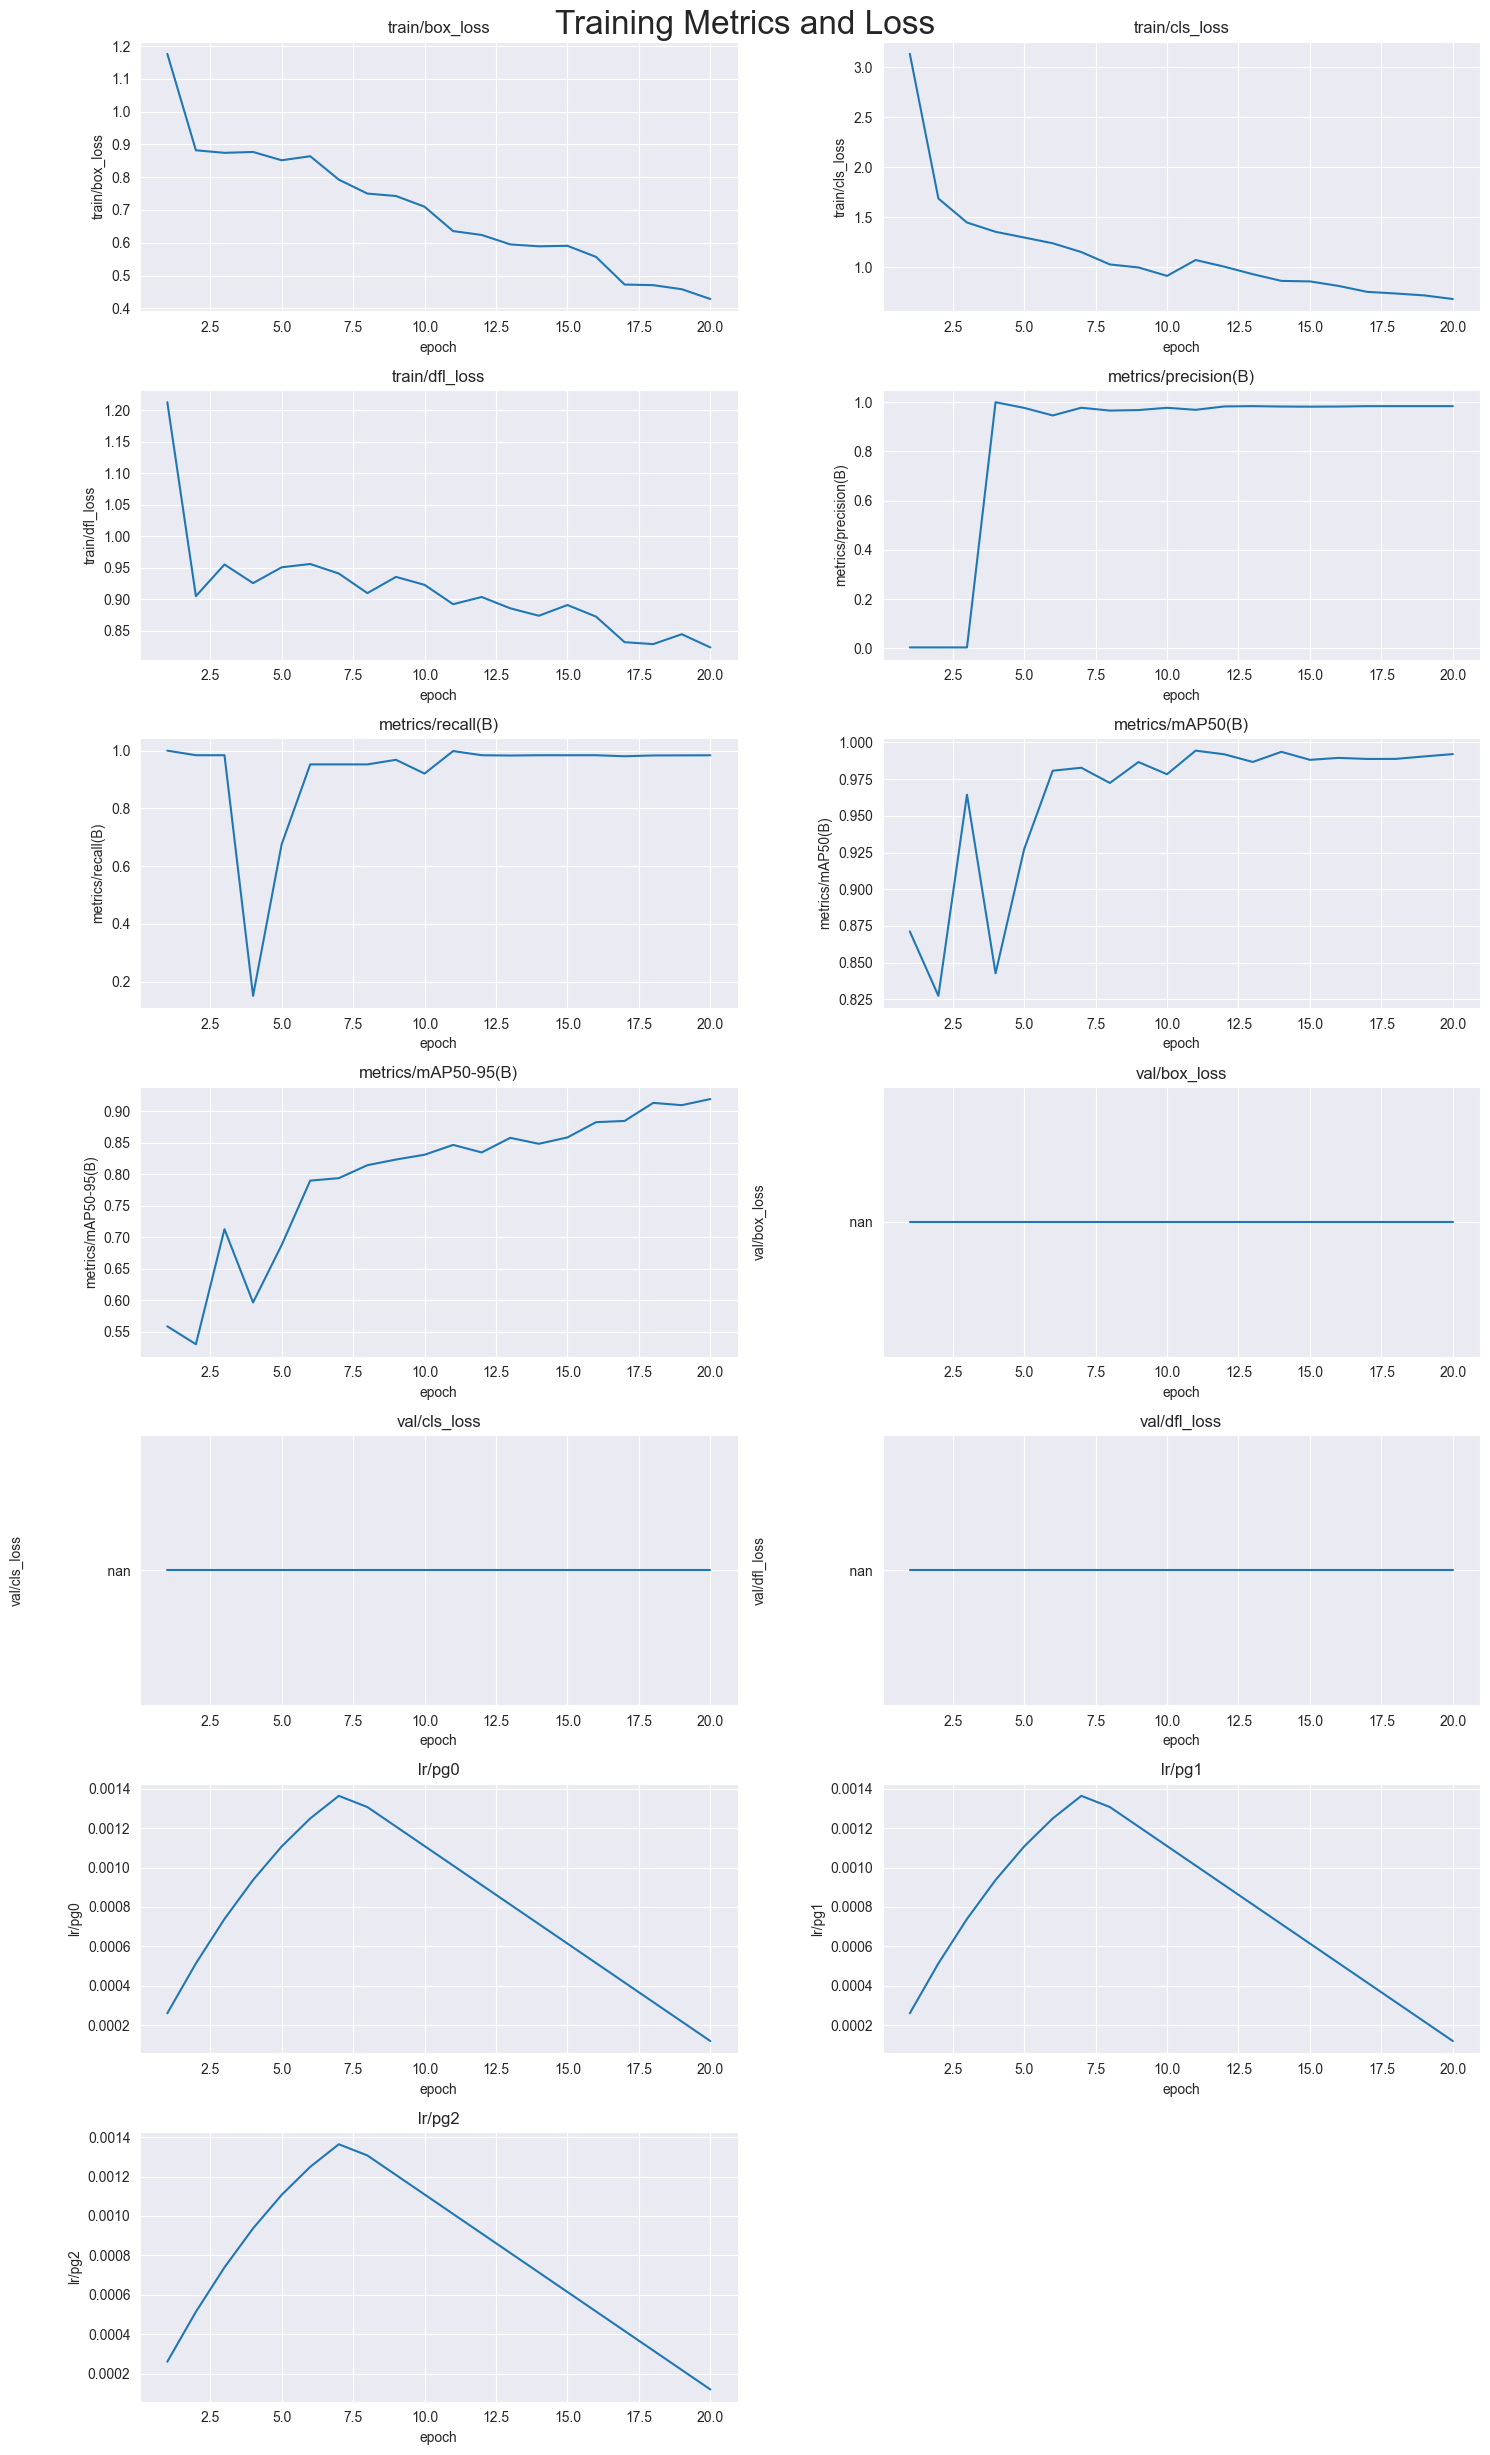

In [66]:
# Define X, y to plot
X = df.epoch
cols = df.columns[1:]

plt.figure(figsize=(15, 25))

for it in range(len(cols)) :
    plt.subplot(7, 2, it+1)
    ax = sns.lineplot(data=df, x=X, y=cols[it])
    ax.set_title(cols[it])
plt.suptitle('Training Metrics and Loss', fontsize=24)
plt.subplots_adjust(top=0.6)
plt.tight_layout()
plt.show()

In [67]:
# Load model with best weights
best_model_path = os.path.join(result_path, 'weights/best.pt')

best_model = YOLO(best_model_path)

In [68]:
# Evaluating the model
result_test = best_model.val()

Ultralytics YOLOv8.2.48  Python-3.11.7 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 4096MiB)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\envs\DataSets\Persian Car Plates.v2i.yolov8-obb\valid\labels.cache... 63 images, 0 backgrounds, 0 corrupt: 100%|██████████| 63/63 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


                   all         63         63      0.997          1      0.995       0.91
Speed: 1.0ms preprocess, 11.2ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\val5


In [69]:
result_test

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000209A05F3BD0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [70]:
keys = ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']

for key in keys :
    print(colored(f'{key} : {result_test.results_dict[key]}', 'green', attrs=['bold']))

metrics/precision(B) : 0.9965329369330659
metrics/recall(B) : 1.0
metrics/mAP50(B) : 0.995
metrics/mAP50-95(B) : 0.9099170095381212


In [71]:
images = os.listdir(test_images)
num_samples = 12

random_images = random.choices(images, k=num_samples)

images = []
for image in random_images :
    image_path = os.path.join(test_images, image)
    images.append(image_path)

images

['C:\\envs\\DataSets\\Persian Car Plates.v2i.yolov8-obb\\test\\images\\462_png.rf.56afd7c388f912b3f984913fc564620b.jpg',
 'C:\\envs\\DataSets\\Persian Car Plates.v2i.yolov8-obb\\test\\images\\440_png.rf.1c86b3d9d0f61137d64bb0467ec9039e.jpg',
 'C:\\envs\\DataSets\\Persian Car Plates.v2i.yolov8-obb\\test\\images\\353_png.rf.17c28f6ba6f218385195d8c7fcc34db9.jpg',
 'C:\\envs\\DataSets\\Persian Car Plates.v2i.yolov8-obb\\test\\images\\301_png.rf.17abf3f5b0b7a9823129bbc60b686d37.jpg',
 'C:\\envs\\DataSets\\Persian Car Plates.v2i.yolov8-obb\\test\\images\\366_png.rf.050c45f153fde23e2ea6b2e82b88daad.jpg',
 'C:\\envs\\DataSets\\Persian Car Plates.v2i.yolov8-obb\\test\\images\\350_png.rf.4a48fe7d2dec13ac0ecff6b5ac070296.jpg',
 'C:\\envs\\DataSets\\Persian Car Plates.v2i.yolov8-obb\\test\\images\\450_png.rf.9ceea270a279a53b8129954e3070abdc.jpg',
 'C:\\envs\\DataSets\\Persian Car Plates.v2i.yolov8-obb\\test\\images\\311_png.rf.6b6e29efda779df57240502602ee2c94.jpg',
 'C:\\envs\\DataSets\\Persian Ca

In [72]:
for image in images :
    result = best_model.predict([image], save=True, conf=0.5, iou=0.7)


0: 640x640 1 Plates, 17.3ms
Speed: 7.6ms preprocess, 17.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

0: 640x640 1 Plates, 23.6ms
Speed: 0.0ms preprocess, 23.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

0: 640x640 1 Plates, 17.3ms
Speed: 2.6ms preprocess, 17.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

0: 640x640 1 Plates, 16.6ms
Speed: 4.5ms preprocess, 16.6ms inference, 9.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

0: 640x640 1 Plates, 18.0ms
Speed: 0.0ms preprocess, 18.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

0: 640x640 1 Plates, 17.1ms
Speed: 7.5ms preprocess, 17.1ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

0: 640x640 1 Pl

In [73]:
# Location of saved predicted images
result_path = result[0].save_dir
print(result_path)

runs\detect\predict5


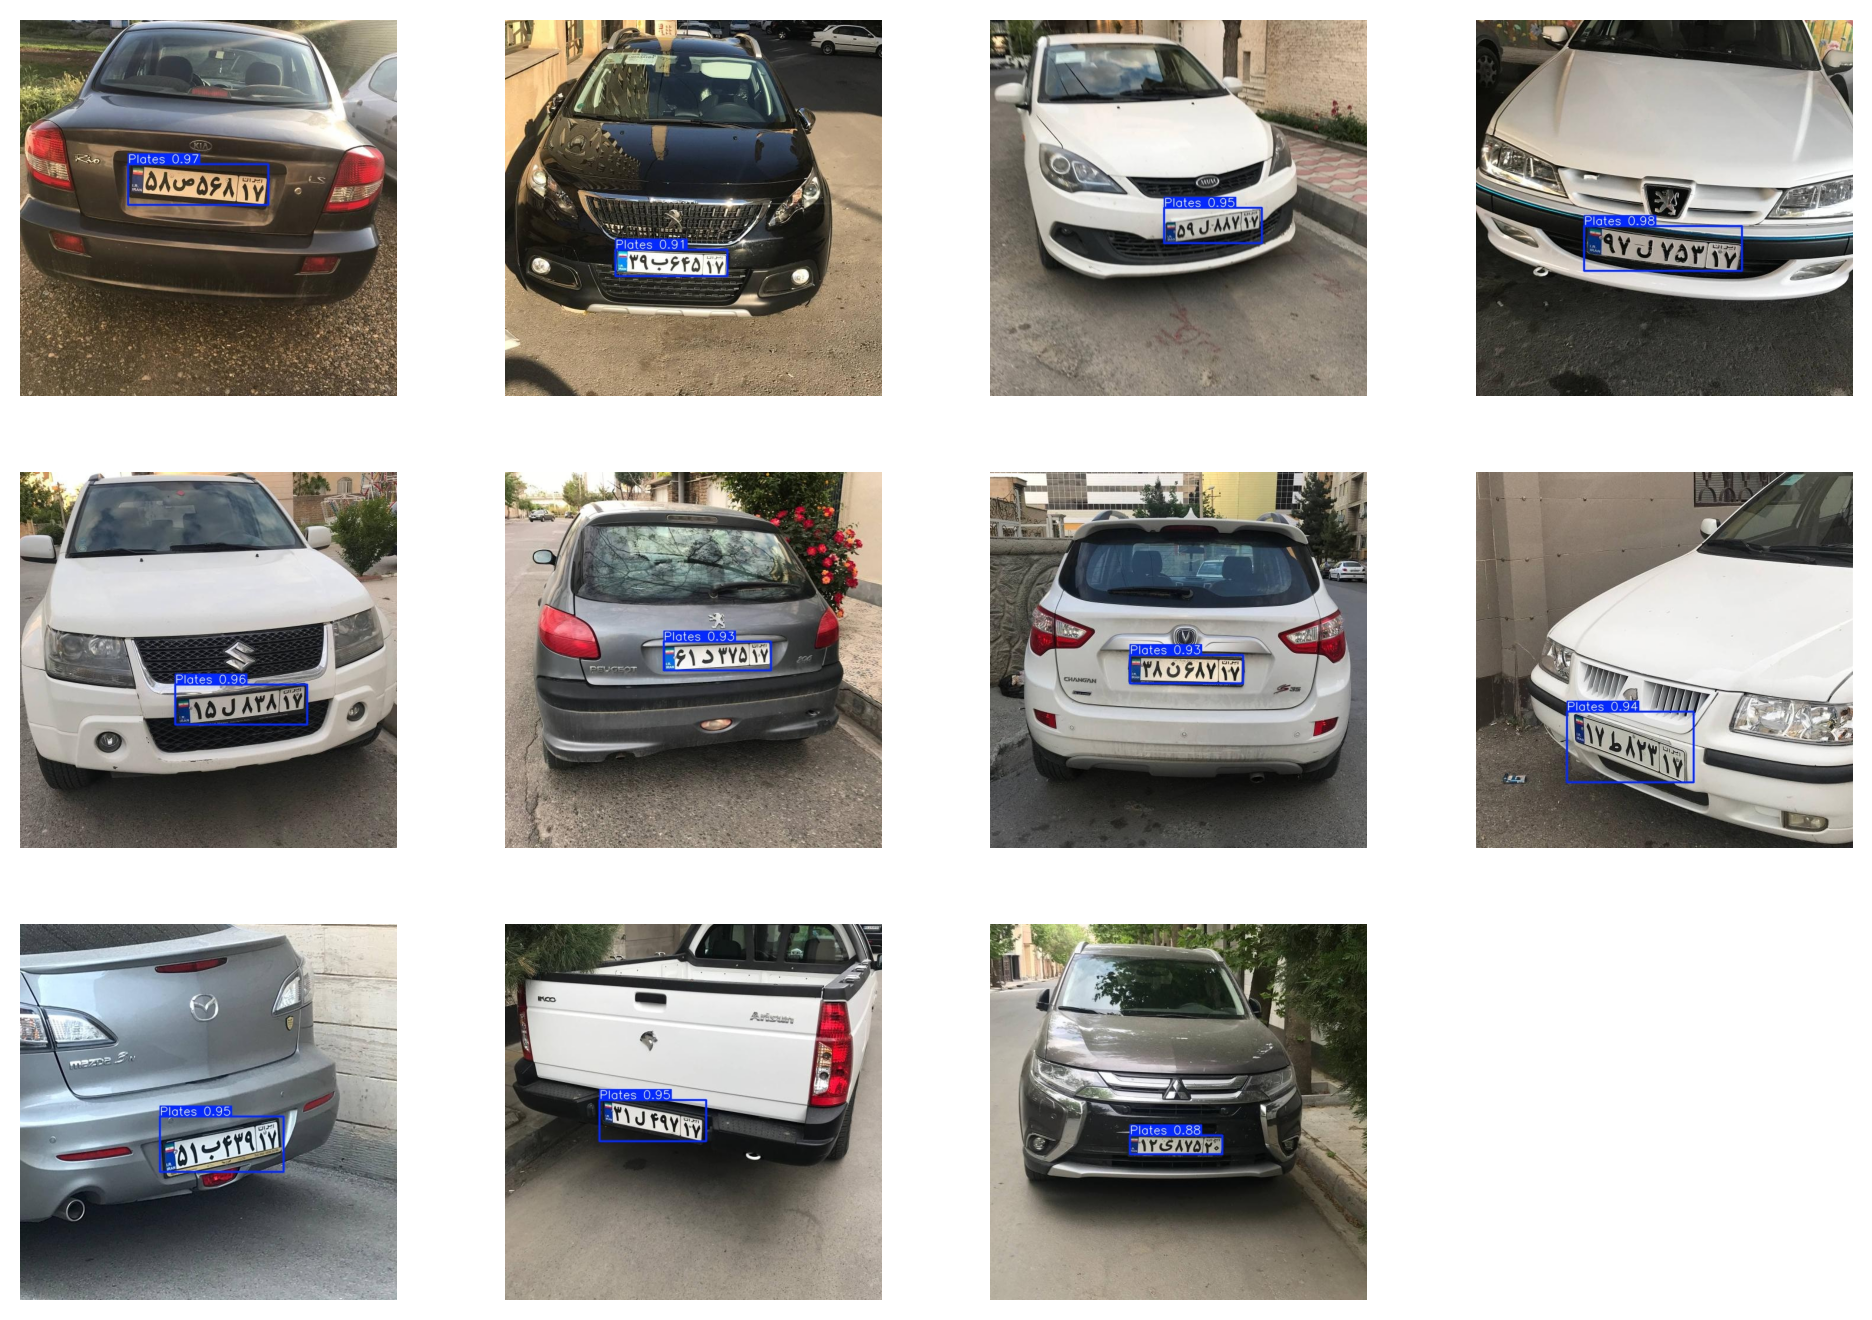

In [74]:
# Show images
i = 1
plt.figure(figsize=(12, 10), dpi=200)
for image in os.listdir(result_path) :
    image_path = os.path.join(result_path, image)
    plt.subplot(3, 4, i)
    plt.imshow(plt.imread(image_path))
    plt.axis('off')
    plt.subplots_adjust(top=0.75)
    i+=1

In [75]:
result[0].boxes.xyxy.tolist()

[[269.87786865234375, 289.4159851074219, 451.999267578125, 338.5813293457031]]

_____________________________________________________________________________

# Phase 3 - Combination Of Phase 1 and Phase 2

In [105]:
Original_img_path = os.path.join(test_images, '211_png.rf.4b780857975f6ab0569285f91841974e.jpg')

result = best_model.predict([Original_img_path], save=True, conf=0.5, iou=0.7)


0: 640x640 1 Plates, 197.9ms
Speed: 9.0ms preprocess, 197.9ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5


In [114]:
os.listdir(result[0].save_dir)[0]

'211_png.rf.4b780857975f6ab0569285f91841974e.jpg'

In [116]:
result[0].save_dir

'runs\\detect\\predict5'

(-0.5, 639.5, 639.5, -0.5)

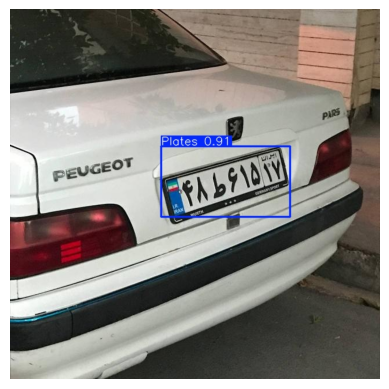

In [117]:
img_path = os.path.join(result[0].save_dir, os.listdir(result[0].save_dir)[0])

plt.imshow(plt.imread(img_path))
plt.axis('off')

In [118]:
bbox = result[0].boxes.xyxy.tolist()
bbox = bbox[0]
bbox

[261.77838134765625, 237.26039123535156, 484.5067138671875, 359.0400390625]

In [119]:
x1 = int(bbox[0])
y1 = int(bbox[1])
x2 = int(bbox[2])
y2 = int(bbox[3])

In [120]:
X = x2 - x1
Y = y2 - y1

In [121]:
img = cv2.imread(img_path)
img2 = img[x1:x2, y1:y2]

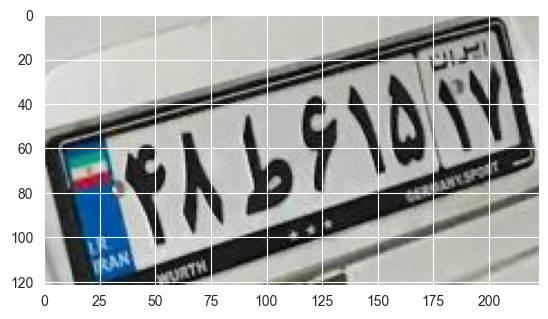

In [122]:
img = cv2.imread(Original_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img[y1:y2, x1:x2]
plt.imshow(img)
# plt.axis('off')

In [123]:
img.shape

(122, 223, 3)

(30, 150, 3)


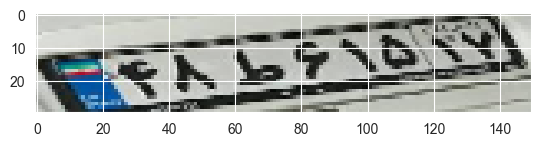

In [124]:
img2 = cv2.resize(img, (150, 30))
print(img2.shape)

plt.imshow(img2)
plt.show()

(-0.5, 80.5, 111.5, -0.5)

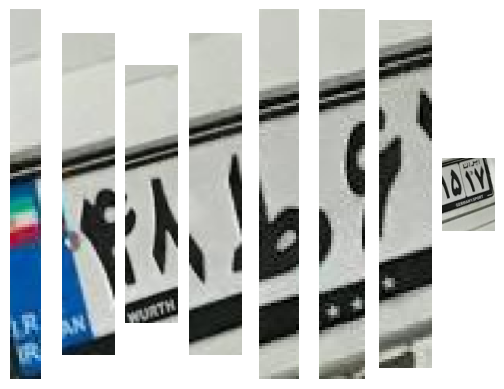

In [125]:
p1 = img[:, 20:30]
p2 = img[:, 30:50]
p3 = img[:, 50:75]
p4 = img[:, 75:95]
p5 = img[:, 95:108]
p6 = img[:, 108:123]
p7 = img[10:, 125:142]
p8 = img[10:, 142:]


plt.subplot(1, 8, 1)
plt.imshow(p1)
plt.axis('off')

plt.subplot(1, 8, 2)
plt.imshow(p2)
plt.axis('off')

plt.subplot(1, 8, 3)
plt.imshow(p3)
plt.axis('off')

plt.subplot(1, 8, 4)
plt.imshow(p4)
plt.axis('off')

plt.subplot(1, 8, 5)
plt.imshow(p5)
plt.axis('off')

plt.subplot(1, 8, 6)
plt.imshow(p6)
plt.axis('off')

plt.subplot(1, 8, 7)
plt.imshow(p7)
plt.axis('off')

plt.subplot(1, 8, 8)
plt.imshow(p8)
plt.axis('off')


In [88]:
Final = os.path.join(working_dir, 'Final')
os.mkdir(Final)

In [89]:
model = torch.load('Best_weight.pt')

In [100]:
first_image_path = os.path.join(Final, 'first.jpg')

plt.imsave(first_image_path, p4)
Image.open(first_image_path)

In [101]:
def Final_Result(img_path) :
    image = Image.open(img_path)
    with torch.no_grad():     
        img_tensor = transform(image).to(device).unsqueeze(0)
        # img_tensor.shape

        model.eval()  

        output = model(img_tensor)
        result = torch.argmax(output, dim=1)
        r = labels_map[result.item()]
        return r

Final_Result(first_image_path)

'char_7'

In [ ]:
img_path = 'C:\\envs\\DataSets\\large-dataset-of-persian-license-plate-characters\\chars\\H\\2\\663_244868.jpg'
Final_Result(img_path)